In [ ]:
!pip install cvxpy[ecos]
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 4.9 MB/s eta 0:00:00


In [ ]:
from dataclasses import dataclass
import numpy as np
import sympy as sym
from scipy.signal import cont2discrete
import scipy.linalg as la
import matplotlib.pyplot as plt
import cvxpy as cp

In [ ]:

# Phase 1: Nonlinear dynamics


@dataclass(frozen=True)
class QuadParams:
    m: float      # mass (kg)
    I: float      # inertia about COM for pitch (kg*m^2)
    l: float      # distance between front/back rotors (m)
    g: float = 9.81

def quad2d_dynamics(t: float,
                    x: np.ndarray,
                    u: np.ndarray,
                    params: QuadParams) -> np.ndarray:
    """
    x = [x, z, theta, xdot, zdot, thetadot]
    u = [u_f, u_b]
    """
    x_pos, z_pos, theta, xdot, zdot, thetadot = x
    u_f, u_b = u

    m = params.m
    I = params.I
    l = params.l
    g = params.g

    # Total thrust and torque
    T   = u_f + u_b
    tau = 0.5 * l * (u_f - u_b)

    # Translational accelerations (world frame)
    ax = (T / m) * np.sin(theta)
    az = (T / m) * np.cos(theta) - g

    # Angular acceleration
    alpha = tau / I

    # State derivatives in the SAME order as state
    dxdt = np.array([
        xdot,        # ẋ
        zdot,        # ż
        thetadot,    # θ̇
        ax,          # ẍ
        az,          # z̈
        alpha        # θ̈
    ], dtype=float)

    return dxdt

def quad_step(x, u, params, dt):
    dxdt = quad2d_dynamics(0.0, x, u, params)
    return x + dt * dxdt

In [ ]:
# @title
params = QuadParams(m=1.0, I=0.02, l=0.3)
print("=== Phase 1 tests ===")

# Hover equilibrium
x0 = np.zeros(6)
u_hover = np.array([params.m*params.g/2, params.m*params.g/2])
dxdt = quad2d_dynamics(0.0, x0, u_hover, params)
print("Hover dx/dt:", dxdt)
assert np.allclose(dxdt, np.zeros(6), atol=1e-8)

# Free-fall z̈ ≈ -g
u_zero = np.array([0., 0.])
dxdt_ff = quad2d_dynamics(0.0, x0, u_zero, params)
print("Free-fall dx/dt:", dxdt_ff)
assert abs(dxdt_ff[4] + params.g) < 1e-8

# One Euler step at hover
x1 = quad_step(x0, u_hover, params, dt=0.01)
print("State after one hover step:", x1)
assert np.allclose(x1, x0, atol=1e-6)



=== Phase 1 tests ===
Hover dx/dt: [0. 0. 0. 0. 0. 0.]
Free-fall dx/dt: [ 0.    0.    0.    0.   -9.81  0.  ]
State after one hover step: [0. 0. 0. 0. 0. 0.]


Hover test

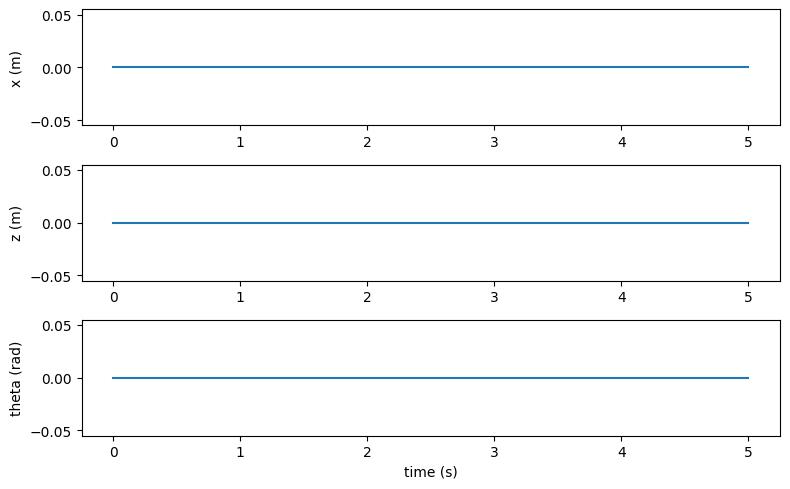

In [ ]:
# @title


# Hover test with current code
params = QuadParams(m=1.0, I=0.02, l=0.3, g=9.81)
m, g = params.m, params.g

dt = 0.005
T_final = 5.0
N = int(T_final / dt)

# state: [x, z, theta, xdot, zdot, thetadot]
x = np.array([0., 0., 0., 0., 0., 0.])

# equal rotor thrusts = hover (total thrust ≈ mg)
u_hover = np.array([m * g / 2, m * g / 2])

xs = np.zeros((N + 1, 6))
ts = np.linspace(0, T_final, N + 1)
xs[0] = x

for k in range(N):
    x = quad_step(x, u_hover, params, dt)  # uses your current quad_step
    xs[k + 1] = x

# Plot x, z, theta vs time
plt.figure(figsize=(8, 5))

plt.subplot(3, 1, 1)
plt.plot(ts, xs[:, 0])
plt.ylabel('x (m)')

plt.subplot(3, 1, 2)
plt.plot(ts, xs[:, 1])
plt.ylabel('z (m)')

plt.subplot(3, 1, 3)
plt.plot(ts, xs[:, 2])
plt.ylabel('theta (rad)')
plt.xlabel('time (s)')

plt.tight_layout()
plt.show()


MOving Platform

In [ ]:
# Phase 2: Moving platform model

def platform_state(t: float,
                   v_p: float,
                   x_p0: float = 0.0,
                   z_p: float = 0.0) -> dict:
    """
    Simple 1D moving platform model (horizontal motion only).

    x_p(t) = x_p0 + v_p * t
    z_p is constant.

    Returns a dict with position and velocity (can be used for references).
    """
    x_p = x_p0 + v_p * t
    z = z_p
    vx_p = v_p
    vz_p = 0.0

    return {
        "x_p": x_p,
        "z_p": z,
        "vx_p": vx_p,
        "vz_p": vz_p,
    }

In [ ]:
# @title
print("=== Phase 2 tests ===")

v_p = 0.5
x_p0 = 1.0
z_p = 0.2
t = 3.0

ps = platform_state(t, v_p, x_p0, z_p)
print(ps)

assert abs(ps["x_p"] - (x_p0 + v_p * t)) < 1e-8
assert abs(ps["z_p"] - z_p) < 1e-8
assert abs(ps["vx_p"] - v_p) < 1e-8
assert abs(ps["vz_p"] - 0.0) < 1e-8



=== Phase 2 tests ===
{'x_p': 2.5, 'z_p': 0.2, 'vx_p': 0.5, 'vz_p': 0.0}


Linearization

In [ ]:
# Phase 3: Continuous-time linearization about hover

def linearize_hover(params: QuadParams) -> tuple[np.ndarray, np.ndarray]:
    """
    Linearize around hover with state ordering:
        x = [x, z, theta, xdot, zdot, thetadot]
    and u = [u_f, u_b].
    """
    m = params.m
    I = params.I
    l = params.l
    g = params.g

    # Symbols in the NEW order
    x_s, z_s, theta, xdot, zdot, thetadot = sym.symbols(
        'x z theta xdot zdot thetadot', real=True
    )
    u_f, u_b = sym.symbols('u_f u_b', real=True)

    x_sym = sym.Matrix([x_s, z_s, theta, xdot, zdot, thetadot])
    u_sym = sym.Matrix([u_f, u_b])

    # Nonlinear dynamics
    T_sym   = u_f + u_b
    tau_sym = 0.5 * l * (u_f - u_b)

    ax_sym = (T_sym / m) * sym.sin(theta)
    az_sym = (T_sym / m) * sym.cos(theta) - g
    alpha_sym = tau_sym / I

    f1 = xdot
    f2 = zdot
    f3 = thetadot
    f4 = ax_sym
    f5 = az_sym
    f6 = alpha_sym

    f = sym.Matrix([f1, f2, f3, f4, f5, f6])

    # Jacobians
    Ac_sym = f.jacobian(x_sym)
    Bc_sym = f.jacobian(u_sym)

    # Hover equilibrium: x* = 0, u_f* = u_b* = m*g/2
    u_hover = m * g / 2.0
    subs_dict = {
        x_s: 0.0,
        z_s: 0.0,
        theta: 0.0,
        xdot: 0.0,
        zdot: 0.0,
        thetadot: 0.0,
        u_f: u_hover,
        u_b: u_hover,
    }

    Ac = np.array(Ac_sym.subs(subs_dict), dtype=float)
    Bc = np.array(Bc_sym.subs(subs_dict), dtype=float)

    return Ac, Bc

In [ ]:
print("Linearized dynamics:")
Ac, Bc = linearize_hover(params)
print("Ac:\n", Ac)
print("Bc:\n", Bc)

Linearized dynamics:
Ac:
 [[0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   1.  ]
 [0.   0.   9.81 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]]
Bc:
 [[ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 1.   1. ]
 [ 7.5 -7.5]]


Discretizatoin

In [ ]:
# Phase 4: Discretization (ZOH)

def discretize_linear_system(Ac: np.ndarray,
                             Bc: np.ndarray,
                             Ts: float) -> tuple[np.ndarray, np.ndarray]:
    """
    Discretize the continuous-time linear system:

        ẋ = Ac x + Bc u

    using zero-order hold with sampling time Ts.

    Returns:
        Ad, Bd such that x_{k+1} = Ad x_k + Bd u_k
    """
    n = Ac.shape[0]
    m = Bc.shape[1]

    C = np.eye(n)
    D = np.zeros((n, m))

    Ad, Bd, _, _, _ = cont2discrete((Ac, Bc, C, D), Ts, method='zoh')
    return Ad, Bd

In [ ]:
# @title
print("=== Phase 4 tests ===")
params = QuadParams(m=1.0, I=0.02, l=0.3)
Ac, Bc = linearize_hover(params)

Ts_small = 0.05
Ad, Bd = discretize_linear_system(Ac, Bc, Ts_small)

# I6 = np.eye(6)
# Ad_approx = I6 + Ac * Ts_small
# Bd_approx = Bc * Ts_small

print("Ad:\n", Ad)
print("Bd:\n", Bd)



=== Phase 4 tests ===
Ad:
 [[1.00000e+00 0.00000e+00 1.22625e-02 5.00000e-02 0.00000e+00 2.04375e-04]
 [0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 5.00000e-02 0.00000e+00]
 [0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 5.00000e-02]
 [0.00000e+00 0.00000e+00 4.90500e-01 1.00000e+00 0.00000e+00 1.22625e-02]
 [0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00]
 [0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00]]
Bd:
 [[ 1.91601563e-05 -1.91601563e-05]
 [ 1.25000000e-03  1.25000000e-03]
 [ 9.37500000e-03 -9.37500000e-03]
 [ 1.53281250e-03 -1.53281250e-03]
 [ 5.00000000e-02  5.00000000e-02]
 [ 3.75000000e-01 -3.75000000e-01]]


LQR

In [ ]:
# Phase 5: Discrete-time LQR (hover servo)

def design_lqr(Ad: np.ndarray,
               Bd: np.ndarray,
               Q: np.ndarray,
               R: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Design a discrete-time LQR controller for

        x_{k+1} = Ad x_k + Bd u_k

    minimizing

        J = sum x_k' Q x_k + u_k' R u_k.

    Returns:
        K : state-feedback gain (u = -K x)
        P : solution of discrete Riccati equation
    """
    # Solve discrete-time Algebraic Riccati Equation
    P = la.solve_discrete_are(Ad, Bd, Q, R)

    # Compute LQR gain: K = (R + B' P B)^-1 B' P A
    K = la.inv(Bd.T @ P @ Bd + R) @ (Bd.T @ P @ Ad)

    return K, P

In [ ]:
# @title
print("=== Phase 5 tests ===")
params = QuadParams(m=1.0, I=0.02, l=0.3)
Ac, Bc = linearize_hover(params)
Ts = 0.05
Ad, Bd = discretize_linear_system(Ac, Bc, Ts)

Q = np.diag([10., 10., 50., 1., 1., 5.])
R = np.diag([0.1, 0.1])

K, P = design_lqr(Ad, Bd, Q, R)
print("K:\n", K)
assert K.shape == (2, 6)

A_cl = Ad - Bd @ K
eigvals = np.linalg.eigvals(A_cl)
print("Closed-loop eigenvalues:", eigvals)
assert np.all(np.abs(eigvals) < 1.0)



=== Phase 5 tests ===
K:
 [[ 1.52189421  5.94543285  7.40573845  1.5904165   3.07900147  1.45028941]
 [-1.52189421  5.94543285 -7.40573845 -1.5904165   3.07900147 -1.45028941]]
Closed-loop eigenvalues: [0.0629463 +0.j         0.92606569+0.06872808j 0.92606569-0.06872808j
 0.85341372+0.j         0.83861814+0.0606882j  0.83861814-0.0606882j ]


MPC

In [ ]:
# @title
# # Phase 6: Linear MPC (discrete-time)

# def setup_mpc_controller(Ad: np.ndarray,
#                          Bd: np.ndarray,
#                          Ts: float,
#                          params: QuadParams,
#                          N: int,
#                          Q: np.ndarray,
#                          R: np.ndarray,
#                          P: np.ndarray,
#                          u_min_real: np.ndarray,
#                          u_max_real: np.ndarray,
#                          theta_max: float):
#     """
#     Build a linear MPC controller for the deviation model:
#         x_{k+1} = Ad x_k + Bd u_k,
#     where u_k is deviation from hover thrust u_eq.

#     We enforce:
#       - state tracking to a reference x_ref(k)
#       - input constraints u_min_real <= u_real <= u_max_real
#       - pitch constraint |theta| <= theta_max

#     Returns:
#         mpc_control(x0, x_ref_traj) -> (u_real_0, pred_x, pred_u_dev)
#     """

#     n = Ad.shape[0]  # 6
#     m = Bd.shape[1]  # 2

#     # Equilibrium input (hover)
#     u_eq = np.array([params.m * params.g / 2.0,
#                      params.m * params.g / 2.0])

#     # ----- MPC optimization variables -----
#     x = cp.Variable((n, N + 1))  # predicted states
#     u = cp.Variable((m, N))      # predicted input deviations (u_dev)

#     # # Convert absolute thrust bounds to deviation bounds
#     # # u_real = u_eq + u_dev  =>  u_dev = u_real - u_eq
#     # u_min_dev = u_min_real - u_eq
#     # u_max_dev = u_max_real - u_eq


#     # Parameters (set each time we call the controller)
#     x0_param = cp.Parameter(n)           # current state
#     x_ref_param = cp.Parameter((n, N+1)) # reference trajectory over horizon

#     constraints = []

#     # Initial condition
#     constraints += [x[:, 0] == x0_param]

#     # Dynamics + constraints over horizon
#     for k in range(N):
#         # Linear dynamics in deviation form
#         constraints += [
#             x[:, k+1] == Ad @ x[:, k] + Bd @ u[:, k]
#         ]

#         # # Input (deviation) bounds mapped from real thrust limits
#         # constraints += [
#         #     u_min_dev <= u[:, k],
#         #     u[:, k] <= u_max_dev
#         # ]
#         # Absolute thrust (this is what must satisfy bounds)
#         u_abs = u_eq + u[:, k]
#         constraints += [
#             u_min_real <= u_abs,
#             u_abs <= u_max_real
#         ]

#         # # Pitch constraint on theta = x[2]
#         # constraints += [
#         #     cp.abs(x[2, k]) <= theta_max
#         # ]
#           # Enforce pitch constraint only from k >= 1
#         if k > 0:
#             constraints += [cp.abs(x[2, k]) <= theta_max]

#     # Also constrain terminal theta
#     constraints += [cp.abs(x[2, N]) <= theta_max]

#     # ----- Cost: tracking + input effort -----
#     cost = 0
#     for k in range(N):
#         dx = x[:, k] - x_ref_param[:, k]  # tracking error
#         du = u[:, k]                      # deviation from hover
#         cost += cp.quad_form(dx, Q) + cp.quad_form(du, R)

#     # Terminal cost
#     dxN = x[:, N] - x_ref_param[:, N]
#     cost += cp.quad_form(dxN, P)

#     # Define the problem
#     prob = cp.Problem(cp.Minimize(cost), constraints)

#     # ---- Closure that actually runs MPC each step ----
#     def mpc_control(x0: np.ndarray,
#                     x_ref_traj: np.ndarray):
#         """
#         x0        : current state (6,)
#         x_ref_traj: reference trajectory over horizon, shape (6, N+1)
#         Returns:
#             u_real_0 : first-step absolute thrust [u_f, u_b]
#             x_pred   : predicted states (6, N+1)
#             u_dev    : predicted input deviations (2, N)
#         """
#         assert x_ref_traj.shape == (n, N+1)

#         x0_param.value = x0
#         x_ref_param.value = x_ref_traj

#         prob.solve(solver=cp.OSQP, warm_start=True)
#         # prob.solve(solver=cp.ECOS, warm_start=True)


#         if prob.status not in ["optimal", "optimal_inaccurate"]:
#             # In a real project you might add fallback logic here
#             raise RuntimeError(f"MPC solve failed with status {prob.status}")

#         u_dev_opt = u[:, 0].value    # first control action in deviation form
#         u_real_0 = u_eq + u_dev_opt  # map back to absolute thrusts

#         return u_real_0, x.value, u.value

#     return mpc_control


MPC w/ soft Constraints

In [ ]:
# Phase 6: Linear MPC (discrete-time)

def setup_mpc_controller(Ad: np.ndarray,
                         Bd: np.ndarray,
                         Ts: float,
                         params: QuadParams,
                         N: int,
                         Q: np.ndarray,
                         R: np.ndarray,
                         P: np.ndarray,
                         u_min_real: np.ndarray,
                         u_max_real: np.ndarray,
                         theta_max: float):
    """
    Build a linear MPC controller for the deviation model:
        x_{k+1} = Ad x_k + Bd u_k,
    where u_k is deviation from hover thrust u_eq.

    We enforce:
      - state tracking to a reference x_ref(k)
      - input constraints u_min_real <= u_real <= u_max_real
      - *soft* pitch constraint |theta| <= theta_max + s_k with slack s_k >= 0

    Returns:
        mpc_control(x0, x_ref_traj) -> (u_real_0, pred_x, pred_u_dev)
    """

    n = Ad.shape[0]  # 6
    m = Bd.shape[1]  # 2

    # Equilibrium input (hover) in ABSOLUTE thrust units
    u_eq = np.array([params.m * params.g / 2.0,
                     params.m * params.g / 2.0])

    # ----- MPC optimization variables -----
    x = cp.Variable((n, N + 1))   # predicted states
    u = cp.Variable((m, N))       # predicted input deviations (u_dev)
    s = cp.Variable(N + 1)        # slack variables for pitch, one per stage

    # Parameters (set each time we call the controller)
    x0_param = cp.Parameter(n)            # current state
    x_ref_param = cp.Parameter((n, N+1))  # reference trajectory over horizon

    constraints = []

    # Initial condition
    constraints += [x[:, 0] == x0_param]

    # Slack nonnegativity
    constraints += [s >= 0]

    # Dynamics + constraints over horizon
    for k in range(N):
        # Linear dynamics in deviation form
        constraints += [
            x[:, k+1] == Ad @ x[:, k] + Bd @ u[:, k]
        ]

        # Absolute thrust bounds (applied to u_eq + deviation)
        u_abs = u_eq + u[:, k]
        constraints += [
            u_min_real <= u_abs,
            u_abs <= u_max_real
        ]

        # Soft pitch constraint: |theta_k| <= theta_max + s_k
        constraints += [
            cp.abs(x[2, k]) <= theta_max + s[k]
        ]

    # Terminal soft pitch constraint at step N
    constraints += [cp.abs(x[2, N]) <= theta_max + s[N]]

    # ----- Cost: tracking + input effort + slack penalty -----
    cost = 0
    for k in range(N):
        dx = x[:, k] - x_ref_param[:, k]  # tracking error
        du = u[:, k]                      # deviation from hover
        cost += cp.quad_form(dx, Q) + cp.quad_form(du, R)

    # Terminal cost
    dxN = x[:, N] - x_ref_param[:, N]
    cost += cp.quad_form(dxN, P)

    # Add slack penalty (soften theta constraint)
    rho = 1e4
    cost += rho * cp.sum_squares(s)

    # Define the problem
    prob = cp.Problem(cp.Minimize(cost), constraints)

    # ---- runs MPC each step ----
    def mpc_control(x0: np.ndarray,
                    x_ref_traj: np.ndarray):
        """
        x0        : current state (6,)
        x_ref_traj: reference trajectory over horizon, shape (6, N+1)
        Returns:
            u_real_0 : first-step absolute thrust [u_f, u_b]
            x_pred   : predicted states (6, N+1)
            u_dev    : predicted input deviations (2, N)
        """
        assert x_ref_traj.shape == (n, N+1)

        x0_param.value = x0
        x_ref_param.value = x_ref_traj

        prob.solve(solver=cp.OSQP, warm_start=True)
        # prob.solve(solver=cp.ECOS, warm_start=True)

        if prob.status not in ["optimal", "optimal_inaccurate"]:
            raise RuntimeError(f"MPC solve failed with status {prob.status}")

        u_dev_opt = u[:, 0].value     # first control action in deviation form
        u_real_0 = u_eq + u_dev_opt   # map back to absolute thrusts

        return u_real_0, x.value, u.value

    return mpc_control


MPC hover test

In [ ]:
params = QuadParams(m=1.0, I=0.02, l=0.3, g=9.81)
Ac, Bc = linearize_hover(params)
Ts = 0.05
Ad, Bd = discretize_linear_system(Ac, Bc, Ts)

Q = np.diag([10., 10., 50., 1., 1., 5.])
R = np.diag([0.1, 0.1])
K, P = design_lqr(Ad, Bd, Q, R)

N_horizon = 20
u_hover = np.array([params.m * params.g / 2,
                    params.m * params.g / 2])
u_min_real = np.array([0.0, 0.0])
u_max_real = np.array([2.0*u_hover[0], 2.0*u_hover[1]])
theta_max = np.deg2rad(25)

mpc_control = setup_mpc_controller(
    Ad, Bd, Ts, params, N_horizon, Q, R, P,
    u_min_real, u_max_real, theta_max
)

# Test: x0 = 0, ref = 0
x0 = np.zeros(6)
x_ref_traj = np.zeros((6, N_horizon+1))

u_real_0, x_pred, u_dev_pred = mpc_control(x0, x_ref_traj)
print("u_real_0:", u_real_0)
print("x_pred[:,0]:", x_pred[:,0])

# Checks
assert np.allclose(x_pred, 0, atol=1e-6)
assert np.allclose(u_real_0, u_hover, atol=1e-3)
print("MPC hover sanity test ")

u_real_0: [4.905 4.905]
x_pred[:,0]: [0. 0. 0. 0. 0. 0.]
MPC hover sanity test 


MPC vs LQR (Unconstrained)

In [ ]:
# Loose constraints so they don't bind
big = 1e6
u_min_real = np.array([-big, -big])
u_max_real = np.array([ big,  big])
theta_max = np.deg2rad(180)  # basically no angle constraint

mpc_control_unc = setup_mpc_controller(
    Ad, Bd, Ts, params, N_horizon, Q, R, P,
    u_min_real, u_max_real, theta_max
)

x0 = np.array([0.5, 0.3, 0.1, 0.0, 0.0, 0.0])
x_ref_traj = np.zeros((6, N_horizon+1))

u_mpc, x_pred, u_dev_pred = mpc_control_unc(x0, x_ref_traj)

u_dev_lqr = -K @ x0
u_lqr = u_hover + u_dev_lqr

print("u_MPC:", u_mpc)
print("u_LQR:", u_lqr)
print("difference:", u_mpc - u_lqr)

assert np.allclose(u_mpc, u_lqr, atol=1e-2)
print("MPC ≈ LQR unconstrained test ")



u_MPC: [1.61986922 4.62287107]
u_LQR: [1.6198492  4.62289109]
difference: [ 2.00204853e-05 -2.00204853e-05]
MPC ≈ LQR unconstrained test 


CLsoed Loop Tracking

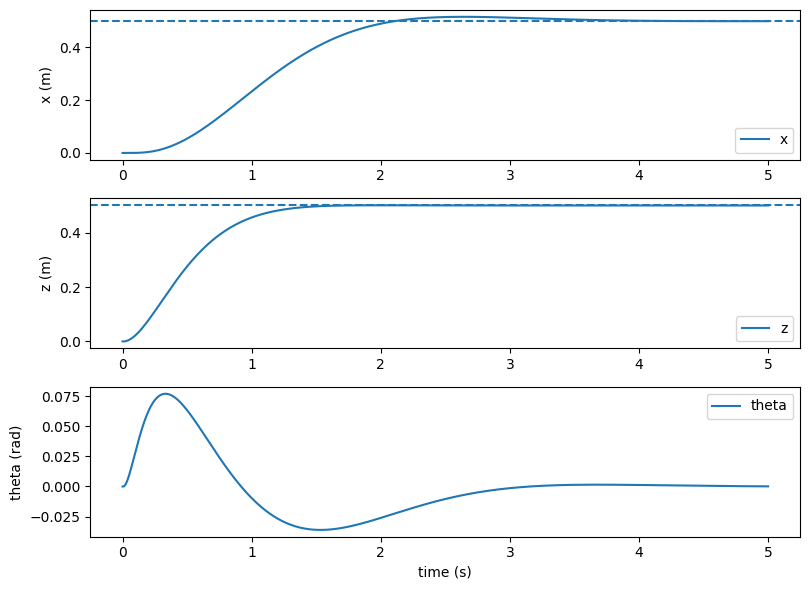

In [ ]:
dt = 0.01     # simulation step
T_sim = 5.0
N_steps = int(T_sim / dt)

x = np.zeros(6)  # start at origin
traj = np.zeros((N_steps+1, 6))
traj[0] = x

x_target = np.array([0.5, 0.5, 0.0, 0.0, 0.0, 0.0])

for k in range(N_steps):
    # Build reference over horizon: constant target
    x_ref_traj = np.tile(x_target.reshape(-1,1), (1, N_horizon+1))

    u_real_0, x_pred, u_dev_pred = mpc_control(x, x_ref_traj)

    # Apply to nonlinear dynamics
    x = quad_step(x, u_real_0, params, dt)
    traj[k+1] = x

t_axis = np.linspace(0, T_sim, N_steps+1)
plt.figure(figsize=(8,6))
plt.subplot(3,1,1)
plt.plot(t_axis, traj[:,0], label='x')
plt.axhline(x_target[0], linestyle='--')
plt.ylabel('x (m)')
plt.legend()

plt.subplot(3,1,2)
plt.plot(t_axis, traj[:,1], label='z')
plt.axhline(x_target[1], linestyle='--')
plt.ylabel('z (m)')
plt.legend()

plt.subplot(3,1,3)
plt.plot(t_axis, traj[:,2], label='theta')
plt.ylabel('theta (rad)')
plt.xlabel('time (s)')
plt.legend()
plt.tight_layout()
plt.show()


Constraint Handling Test

Max |theta| (deg): 31.69759329430021
Theta limit (deg): 14.999999999999998
Min thrust per rotor: [2.45249562 2.45249954]
Max thrust per rotor: [7.35750046 7.3575007 ]
Thrust limits per rotor: [2.4525 2.4525] [7.3575 7.3575]
❌ MPC violated the theta constraint!
✅ No thrust constraint violation.


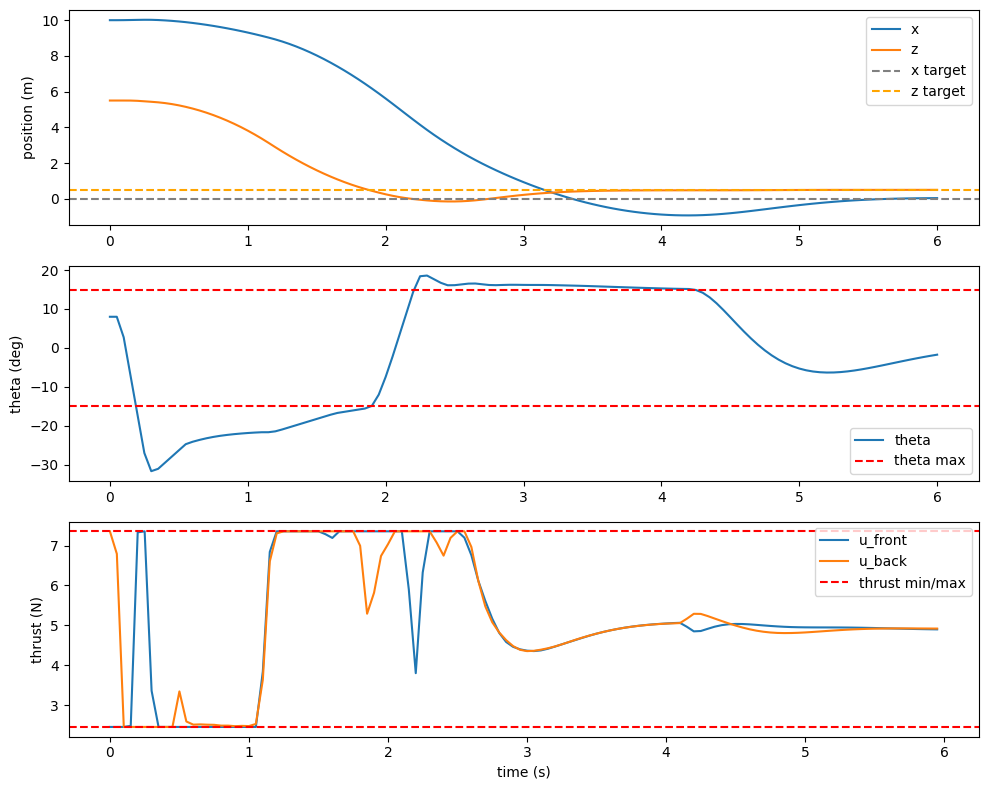

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Build linear model and MPC
params = QuadParams(m=1.0, I=0.02, l=0.3, g=9.81)

# Linearize around hover and discretize
Ac, Bc = linearize_hover(params)
Ts = 0.05  # MPC sample time
Ad, Bd = discretize_linear_system(Ac, Bc, Ts)

# State cost
Q = np.diag([
    20.0,   # x
    20.0,   # z
    50.0,   # theta
    2.0,    # xdot
    2.0,    # zdot
    5.0,    # thetadot
])

# Input cost (penalize thrust deviations)
u_hover = np.array([params.m * params.g / 2.0,
                    params.m * params.g / 2.0])
du_tol = 0.5 * u_hover[0]
R = np.diag([1.0 / du_tol**2, 1.0 / du_tol**2])

# LQR terminal cost
K_lqr, P = design_lqr(Ad, Bd, Q, R)

# Horizon
N_horizon = 20

# Tight constraints for test:
#   - thrust per rotor between 0.5*hover and 1.5*hover
#   - pitch |theta| <= 10 degrees
u_min_real = 0.5 * u_hover
u_max_real = 1.5 * u_hover
theta_max = np.deg2rad(15.0)

mpc_control = setup_mpc_controller(
    Ad=Ad,
    Bd=Bd,
    Ts=Ts,
    params=params,
    N=N_horizon,
    Q=Q,
    R=R,
    P=P,
    u_min_real=u_min_real,
    u_max_real=u_max_real,
    theta_max=theta_max
)

# 2. Closed-loop simulation


# Simulate nonlinear dynamics with MPC in the loop
dt = Ts
T_sim = 6.0
N_steps = int(T_sim / dt)

# Initial state: big lateral offset + small tilt (inside theta_max)
x = np.array([
    10.0,                    # x (m)
    5.5,                    # z (m)
    np.deg2rad(8.0),        # theta (rad) < theta_max
    0.0,                    # xdot
    0.0,                    # zdot
    0.0                     # thetadot
])

# Target: hover at (0, 0.5) upright
x_target = np.array([0.0, 0.5, 0.0, 0.0, 0.0, 0.0])

traj = np.zeros((N_steps + 1, 6))
us = np.zeros((N_steps, 2))
t_axis = np.linspace(0.0, T_sim, N_steps + 1)
traj[0] = x

for k in range(N_steps):
    # Build reference over horizon: constant target
    x_ref_traj = np.tile(x_target.reshape(-1, 1), (1, N_horizon + 1))

    # MPC: get optimal first control input (absolute thrusts)
    u_real_0, x_pred, u_dev_pred = mpc_control(x, x_ref_traj)

    # Store control
    us[k] = u_real_0

    # Apply to nonlinear dynamics
    x = quad_step(x, u_real_0, params, dt)
    traj[k + 1] = x

# 3. Check constraints

theta_traj = traj[:, 2]

theta_violation = np.any(np.abs(theta_traj) > theta_max + 1e-3)
thrust_low_violation = np.any(us < (u_min_real - 1e-3))
thrust_high_violation = np.any(us > (u_max_real + 1e-3))
thrust_violation = thrust_low_violation or thrust_high_violation

print("Max |theta| (deg):", np.rad2deg(np.max(np.abs(theta_traj))))
print("Theta limit (deg):", np.rad2deg(theta_max))
print("Min thrust per rotor:", us.min(axis=0))
print("Max thrust per rotor:", us.max(axis=0))
print("Thrust limits per rotor:", u_min_real, u_max_real)

if theta_violation:
    print("❌ MPC violated the theta constraint!")
else:
    print("✅ No theta constraint violation.")

if thrust_violation:
    print("❌ MPC violated the thrust constraints!")
else:
    print("✅ No thrust constraint violation.")

# 4. Plots

plt.figure(figsize=(10, 8))

# x and z
plt.subplot(3, 1, 1)
plt.plot(t_axis, traj[:, 0], label='x')
plt.plot(t_axis, traj[:, 1], label='z')
plt.axhline(x_target[0], linestyle='--', color='gray', label='x target')
plt.axhline(x_target[1], linestyle='--', color='orange', label='z target')
plt.ylabel('position (m)')
plt.legend()

# theta with bounds
plt.subplot(3, 1, 2)
plt.plot(t_axis, np.rad2deg(theta_traj), label='theta')
plt.axhline(np.rad2deg(theta_max), linestyle='--', color='red', label='theta max')
plt.axhline(-np.rad2deg(theta_max), linestyle='--', color='red')
plt.ylabel('theta (deg)')
plt.legend()

# thrusts with bounds
plt.subplot(3, 1, 3)
time_u = t_axis[:-1]
plt.plot(time_u, us[:, 0], label='u_front')
plt.plot(time_u, us[:, 1], label='u_back')
plt.axhline(u_min_real[0], linestyle='--', color='red', label='thrust min/max')
plt.axhline(u_max_real[0], linestyle='--', color='red')
plt.xlabel('time (s)')
plt.ylabel('thrust (N)')
plt.legend()

plt.tight_layout()
plt.show()


Nonlinear closed-loop simulation with MPC tracking moving platform

In [ ]:
def build_tracking_mpc(params: QuadParams,
                       Ts: float = 0.05,
                       N_horizon: int = 20,
                       theta_max_deg: float = 12.0):
    """
    Build an MPC controller configured for tracking the moving platform.
    Returns (mpc_control, Ad, Bd, Q, R, P, u_min_real, u_max_real, theta_max).
    """
    # Linearization & discretization
    Ac, Bc = linearize_hover(params)
    Ad, Bd = discretize_linear_system(Ac, Bc, Ts)

    # State cost: track x,z and keep fairly upright
    Q = np.diag([
        20.0,   # x
        20.0,   # z
        80.0,   # theta
        2.0,    # xdot
        2.0,    # zdot
        5.0,    # thetadot
    ])

    # Input cost: penalize big thrust deviations
    u_hover = np.array([params.m * params.g / 2.0,
                        params.m * params.g / 2.0])
    du_tol = 0.5 * u_hover[0]
    R = np.diag([1.0 / du_tol**2, 1.0 / du_tol**2])

    # Terminal cost from LQR
    K_lqr, P = design_lqr(Ad, Bd, Q, R)

    # Thrust limits: between 0.5 and 1.5 of hover thrust per rotor
    u_min_real = 0.5 * u_hover
    u_max_real = 1.5 * u_hover

    theta_max = np.deg2rad(theta_max_deg)

    mpc_control = setup_mpc_controller(
        Ad=Ad,
        Bd=Bd,
        Ts=Ts,
        params=params,
        N=N_horizon,
        Q=Q,
        R=R,
        P=P,
        u_min_real=u_min_real,
        u_max_real=u_max_real,
        theta_max=theta_max,
    )

    return mpc_control, Ad, Bd, Q, R, P, u_min_real, u_max_real, theta_max


In [ ]:
def simulate_mpc_tracking(params: QuadParams,
                          v_platform: float = 0.3,
                          z_platform: float = 0.5,
                          T_sim: float = 8.0,
                          Ts: float = 0.05,
                          N_horizon: int = 20,
                          theta_max_deg: float = 12.0):
    """
    Nonlinear closed-loop simulation:
      - platform moves horizontally at v_platform at fixed height z_platform
      - quad uses MPC to track the platform position & velocity
    """

    # Build controller
    (mpc_control,
     Ad, Bd, Q, R, P,
     u_min_real, u_max_real, theta_max) = build_tracking_mpc(
        params, Ts=Ts, N_horizon=N_horizon, theta_max_deg=theta_max_deg
    )

    dt = Ts  # for now, use same dt for plant and MPC
    N_steps = int(T_sim / dt)

    # Initial state: start behind and below platform, small tilt
    x = np.array([
        -0.5,                 # x
        0.2,                  # z
        np.deg2rad(5.0),      # theta
        0.0,                  # xdot
        0.0,                  # zdot
        0.0,                  # thetadot
    ])

    # Logging
    traj = np.zeros((N_steps + 1, 6))
    us = np.zeros((N_steps, 2))
    platform_traj = np.zeros((N_steps + 1, 2))  # [x_p, z_p]
    t_axis = np.linspace(0.0, T_sim, N_steps + 1)
    traj[0] = x

    # For visualizing θ bounds
    theta_max = np.deg2rad(theta_max_deg)

    for k in range(N_steps):
        t_k = k * dt

        # Platform state at current time
        p = platform_state(t_k, v_platform, x_p0=0.0, z_p=z_platform)
        x_p, z_p, vx_p, vz_p = p["x_p"], p["z_p"], p["vx_p"], p["vz_p"]
        platform_traj[k] = [x_p, z_p]

        # Build reference trajectory over the MPC horizon
        t_horizon = t_k + Ts * np.arange(N_horizon + 1)
        x_ref_traj = np.zeros((6, N_horizon + 1))
        for j, tj in enumerate(t_horizon):
            p_j = platform_state(tj, v_platform, x_p0=0.0, z_p=z_platform)
            x_ref_traj[0, j] = p_j["x_p"]   # desired x = platform x
            x_ref_traj[1, j] = p_j["z_p"]   # desired z = platform z
            x_ref_traj[2, j] = 0.0          # upright
            x_ref_traj[3, j] = p_j["vx_p"]  # desired xdot = platform vx
            x_ref_traj[4, j] = p_j["vz_p"]  # desired zdot = 0
            x_ref_traj[5, j] = 0.0          # no rotation rate

        # Calls MPC
        u_real_0, x_pred, u_dev_pred = mpc_control(x, x_ref_traj)

        us[k] = u_real_0

        # Apply to nonlinear plant
        x = quad_step(x, u_real_0, params, dt)
        traj[k + 1] = x

    # Last platform sample
    p_end = platform_state(T_sim, v_platform, x_p0=0.0, z_p=z_platform)
    platform_traj[-1] = [p_end["x_p"], p_end["z_p"]]

    # Plot results
    plt.figure(figsize=(10, 8))

    # x/z with platform
    plt.subplot(3, 1, 1)
    plt.plot(t_axis, traj[:, 0], label='quad x')
    plt.plot(t_axis, platform_traj[:, 0], '--', label='platform x')
    plt.ylabel('x (m)')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(t_axis, traj[:, 1], label='quad z')
    plt.plot(t_axis, platform_traj[:, 1], '--', label='platform z')
    plt.ylabel('z (m)')
    plt.legend()

    # theta with bounds
    plt.subplot(3, 1, 3)
    plt.plot(t_axis, np.rad2deg(traj[:, 2]), label='theta (deg)')
    plt.axhline(theta_max_deg, linestyle='--', color='red', label='theta max')
    plt.axhline(-theta_max_deg, linestyle='--', color='red')
    plt.xlabel('time (s)')
    plt.ylabel('theta (deg)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Thrust plot
    time_u = t_axis[:-1]
    plt.figure(figsize=(8, 4))
    plt.plot(time_u, us[:, 0], label='u_front')
    plt.plot(time_u, us[:, 1], label='u_back')
    plt.axhline(u_min_real[0], linestyle='--', color='red', label='thrust bounds')
    plt.axhline(u_max_real[0], linestyle='--', color='red')
    plt.xlabel('time (s)')
    plt.ylabel('thrust (N)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return traj, us, platform_traj, t_axis


Running NL CL MPC

/usr/local/lib/python3.12/dist-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


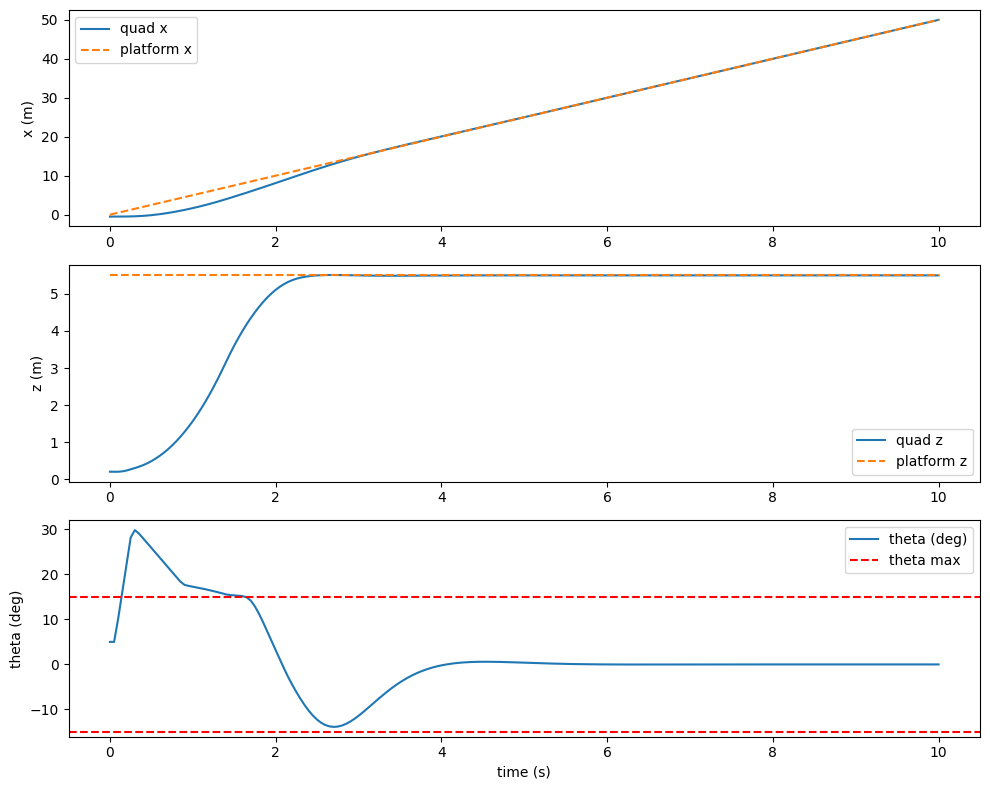

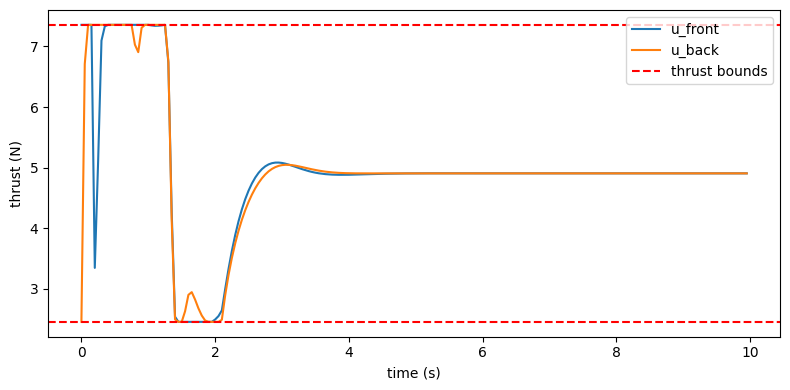

In [ ]:
params = QuadParams(m=1.0, I=0.02, l=0.3, g=9.81)

traj, us, platform_traj, t_axis = simulate_mpc_tracking(
    params,
    v_platform=5.0,      # platform speed [m/s]
    z_platform=5.5,      # platform height [m]
    T_sim=10.0,
    Ts=0.05,
    N_horizon=50,
    theta_max_deg=15.0,  # soft/hard target range
)


In [ ]:
import sys
import os

# Check if running in Colab
if 'google.colab' in sys.modules:
    !pip install -q pyomo
    !apt-get install -y -qq glpk-utils
    !apt-get install -y -qq coinor-cbc

    # Download and install IPOPT
    !wget -N -q "https://matematica.unipv.it/gualandi/solvers/ipopt-linux64.zip"
    !unzip -o -q ipopt-linux64

    # Make it executable and move to a path accessible by Pyomo
    !chmod +x ipopt
    !mv ipopt /usr/local/bin/

Starting Simulation...


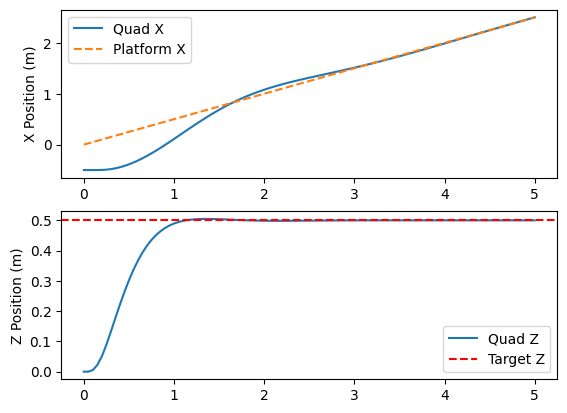

In [ ]:
import numpy as np
import scipy.signal
import scipy.linalg
import pyomo.environ as pyo
import matplotlib.pyplot as plt
from dataclasses import dataclass

# 1. System Dynamics & Linearization

@dataclass(frozen=True)
class QuadParams:
    m: float = 1.0
    I: float = 0.02
    l: float = 0.3
    g: float = 9.81

def quad2d_dynamics(t, x, u, params):
    # Unpack state: [x, z, theta, xdot, zdot, thetadot]
    theta = x[2]
    u_f, u_b = u[0], u[1]

    T = u_f + u_b
    tau = (u_f - u_b) * params.l / 2.0  # Assuming standard torque arm

    # Dynamics
    x_ddot = -(T / params.m) * np.sin(theta)
    z_ddot = (T / params.m) * np.cos(theta) - params.g
    theta_ddot = tau / params.I

    return np.array([x[3], x[4], x[5], x_ddot, z_ddot, theta_ddot])

def get_linearized_model(params, Ts):
    # Linearize about hover (theta=0, u_f=u_b=mg/2)
    u_hover = params.m * params.g / 2.0

    # Continuous Jacobian A (6x6)
    Ac = np.zeros((6, 6))
    Ac[0, 3] = 1.0
    Ac[1, 4] = 1.0
    Ac[2, 5] = 1.0
    Ac[3, 2] = -params.g  # linearized gravity/angle coupling

    # Continuous Jacobian B (6x2)
    Bc = np.zeros((6, 2))
    Bc[3, 0] = 0.0 # sin(0) = 0
    Bc[3, 1] = 0.0
    Bc[4, 0] = 1.0 / params.m
    Bc[4, 1] = 1.0 / params.m
    Bc[5, 0] =  (params.l / 2.0) / params.I
    Bc[5, 1] = -(params.l / 2.0) / params.I

    # Discretize
    sys = (Ac, Bc, np.eye(6), np.zeros((6,2)))
    Ad, Bd, Cd, Dd, dt = scipy.signal.cont2discrete(sys, Ts)
    return Ad, Bd

# 2. Lab 11 Helper Functions


def platform_state(t, v_p, z_p):
    """Generates the reference for a specific time t."""
    x_p = v_p * t # Simple constant velocity model starting at 0
    return np.array([x_p, z_p, 0, v_p, 0, 0])

def get_ref_trajectory(t_start, N, Ts, v_p, z_p):
    """Generates the full reference trajectory for the horizon."""
    nx = 6
    nu = 2
    xref = np.zeros((nx, N+1))
    uref = np.zeros((nu, N+1)) # deviations are 0 at hover

    for k in range(N+1):
        t_k = t_start + k*Ts
        xref[:, k] = platform_state(t_k, v_p, z_p)

    return xref, uref

# 3. Lab 11 MPC Setup (The Pyomo Part)

def create_cftoc_with_slack(A, B, P, Q, R, Qs, N, x0, uL, uU, theta_lim):
    model = pyo.ConcreteModel()

    nx = np.size(A, 0)
    nu = np.size(B, 1)

    # Indices
    model.tidx = pyo.Set(initialize=range(N+1))
    model.xidx = pyo.Set(initialize=range(nx))
    model.uidx = pyo.Set(initialize=range(nu))

    # Variables
    model.x = pyo.Var(model.xidx, model.tidx)
    model.u = pyo.Var(model.uidx, model.tidx, bounds=(uL, uU)) # Input constraints (Hard)

    # Slack variable for theta (state index 2)
    model.s_theta = pyo.Var(model.tidx, domain=pyo.NonNegativeReals)

    # Mutable Parameters
    model.x0 = pyo.Param(model.xidx, initialize=lambda m, i: x0[i], mutable=True)
    model.xref = pyo.Param(model.xidx, model.tidx, initialize=0.0, mutable=True)
    model.uref = pyo.Param(model.uidx, model.tidx, initialize=0.0, mutable=True)

    # Objective
    def objective_rule(m):
        costX = sum((m.x[i, t] - m.xref[i, t]) * Q[i, j] * (m.x[j, t] - m.xref[j, t])
                    for t in m.tidx for i in m.xidx for j in m.xidx if t < N)
        costU = sum((m.u[i, t] - m.uref[i, t]) * R[i, j] * (m.u[j, t] - m.uref[j, t])
                    for t in m.tidx for i in m.uidx for j in m.uidx if t < N)
        costTerminal = sum((m.x[i, N] - m.xref[i, N]) * P[i, j] * (m.x[j, N] - m.xref[j, N])
                           for i in m.xidx for j in m.xidx)
        # Slack penalty
        costSlack = sum(Qs * m.s_theta[t]**2 for t in m.tidx)

        return costX + costU + costTerminal + costSlack

    model.cost = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

    # Constraints
    # 1. Dynamics
    def dynamics_rule(m, i, t):
        if t < N:
            return m.x[i, t+1] == sum(A[i, j] * m.x[j, t] for j in m.xidx) + \
                                  sum(B[i, j] * m.u[j, t] for j in m.uidx)
        return pyo.Constraint.Skip
    model.dynamics_cons = pyo.Constraint(model.xidx, model.tidx, rule=dynamics_rule)

    # 2. Initial Condition
    def init_rule(m, i):
        return m.x[i, 0] == m.x0[i]
    model.init_cons = pyo.Constraint(model.xidx, rule=init_rule)

    # 3. Soft Constraint on Theta (Index 2)
    # -theta_lim - s <= theta <= theta_lim + s
    def theta_upper_rule(m, t):
        return m.x[2, t] <= theta_lim + m.s_theta[t]
    model.theta_upper_cons = pyo.Constraint(model.tidx, rule=theta_upper_rule)

    def theta_lower_rule(m, t):
        return m.x[2, t] >= -theta_lim - m.s_theta[t]
    model.theta_lower_cons = pyo.Constraint(model.tidx, rule=theta_lower_rule)

    return model

def solve_cftoc(model, solver, x0, xref, uref):
    # Update parameters
    for i in model.xidx:
        model.x0[i].set_value(x0[i])

    for t in model.tidx:
        for i in model.xidx:
            model.xref[i, t].set_value(xref[i, t])
        for i in model.uidx:
            model.uref[i, t].set_value(uref[i, t])

    # Solve
    results = solver.solve(model)

    # Extract
    feas = (str(results.solver.termination_condition) == "optimal")

    uOpt0 = np.array([pyo.value(model.u[i, 0]) for i in model.uidx])

    return feas, uOpt0

# 4. Simulation Loop from lab code stuff

def simulate_mpc(x0, model, solver, Tsim, Ts, N, params, v_p, z_p, u_hover_val):
    nx = 6
    nu = 2
    n_steps = int(Tsim / Ts)

    xOpt = np.zeros((nx, n_steps + 1))
    uOpt = np.zeros((nu, n_steps))
    xOpt[:, 0] = x0

    print("Starting Simulation...")
    for t in range(n_steps):
        # 1. Get Reference for the Horizon
        current_time = t * Ts
        xref_horizon, uref_horizon = get_ref_trajectory(current_time, N, Ts, v_p, z_p)

        # 2. Solve MPC (Linear Deviation Model)
        feas, u_dev = solve_cftoc(model, solver, xOpt[:, t], xref_horizon, uref_horizon)

        if not feas:
            print(f"Infeasible at step {t}")
            break

        # 3. Apply to Nonlinear System
        # Recover absolute input
        u_abs = u_dev + u_hover_val
        uOpt[:, t] = u_abs

        # Integrate nonlinear dynamics ( Euler)

        x_dot = quad2d_dynamics(0, xOpt[:, t], u_abs, params)
        xOpt[:, t+1] = xOpt[:, t] + x_dot * Ts

    return xOpt, uOpt

# 5. Main Execution

# Parameters
params = QuadParams()
Ts = 0.05
Tsim = 5.0
N = 20
v_platform = 0.5
z_platform = 0.5

Ad, Bd = get_linearized_model(params, Ts)
nx = 6
nu = 2

# Costs
Q = np.diag([20, 20, 50, 1, 1, 5])
R = np.eye(2) * 0.1
Qs = 1000.0 # Slack weight
P = Q # Terminal cost (approx)

# Constraints
u_hover_val = params.m * params.g / 2.0
u_min_real = 0.0
u_max_real = 1.5 * u_hover_val

# Convert absolute limits to DEVIATION limits for the linear solver
uL = u_min_real - u_hover_val
uU = u_max_real - u_hover_val
theta_lim = np.deg2rad(15)

# Setup Solver
solver = pyo.SolverFactory('ipopt')

# Create Model ONCE
model = create_cftoc_with_slack(Ad, Bd, P, Q, R, Qs, N, np.zeros(nx), uL, uU, theta_lim)

# Run Simulation
x0 = np.array([-0.5, 0.0, 0.0, 0.0, 0.0, 0.0]) # Start behind and on ground
xOpt, uOpt = simulate_mpc(x0, model, solver, Tsim, Ts, N, params, v_platform, z_platform, u_hover_val)

# Plotting
time = np.arange(xOpt.shape[1]) * Ts
plt.figure()
plt.subplot(2,1,1)
plt.plot(time, xOpt[0,:], label='Quad X')
plt.plot(time, time*v_platform, '--', label='Platform X')
plt.legend()
plt.ylabel('X Position (m)')

plt.subplot(2,1,2)
plt.plot(time, xOpt[1,:], label='Quad Z')
plt.axhline(z_platform, color='r', linestyle='--', label='Target Z')
plt.legend()
plt.ylabel('Z Position (m)')
plt.show()

In [ ]:
# @title
import numpy as np
import scipy.signal
import cvxpy as cp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from dataclasses import dataclass

# 1. System Dynamics (Quad & Platform)

@dataclass(frozen=True)
class QuadParams:
    m: float = 1.0
    I: float = 0.02
    l: float = 0.3
    g: float = 9.81

class RandomPlatform:
    def __init__(self, x0, z0, vx0, vz0, dt):
        self.state = np.array([x0, z0, 0, vx0, vz0, 0]) # Format matches quad state size
        self.dt = dt
        self.target_vx = vx0
        self.target_vz = vz0

    def step(self):
        # 1. Randomly change target velocity occasionally
        if np.random.rand() < 0.05: # 5% chance per step to change intention
            self.target_vx += np.random.uniform(-0.5, 0.5)
            self.target_vz += np.random.uniform(-0.2, 0.2)

            # Clamp velocities to keep it reasonable
            self.target_vx = np.clip(self.target_vx, 0.0, 2.0) # Always moving forward
            self.target_vz = np.clip(self.target_vz, -0.5, 0.5)

        # 2. Smoothly accelerate towards target velocity (Physics)
        k_smooth = 0.1
        ax = k_smooth * (self.target_vx - self.state[3])
        az = k_smooth * (self.target_vz - self.state[4])

        # 3. Update State (Euler Integration)
        self.state[3] += ax * self.dt  # vx
        self.state[4] += az * self.dt  # vz
        self.state[0] += self.state[3] * self.dt # x
        self.state[1] += self.state[4] * self.dt # z

        # Hard floor for platform
        if self.state[1] < 0.1: self.state[1] = 0.1

        return self.state

def quad2d_dynamics(x, u, params):
    theta = x[2]
    u_f, u_b = u[0], u[1]
    T = u_f + u_b
    tau = (u_f - u_b) * params.l / 2.0

    # Dynamics
    x_ddot = -(T / params.m) * np.sin(theta)
    z_ddot = (T / params.m) * np.cos(theta) - params.g
    theta_ddot = tau / params.I

    return np.array([x[3], x[4], x[5], x_ddot, z_ddot, theta_ddot])

def get_linearized_model(params, Ts):
    Ac = np.zeros((6, 6))
    Ac[0, 3] = 1.0; Ac[1, 4] = 1.0; Ac[2, 5] = 1.0; Ac[3, 2] = -params.g

    Bc = np.zeros((6, 2))
    Bc[4, 0] = 1.0 / params.m; Bc[4, 1] = 1.0 / params.m
    Bc[5, 0] = (params.l/2.0)/params.I; Bc[5, 1] = -(params.l/2.0)/params.I

    sys = (Ac, Bc, np.eye(6), np.zeros((6,2)))
    Ad, Bd, _, _, _ = scipy.signal.cont2discrete(sys, Ts)
    return Ad, Bd

# 2. MPC Helper (Prediction)

def get_ref_trajectory(current_platform_state, N, Ts):
    """
    Predicts platform future assuming CONSTANT VELOCITY from the current moment.
    """
    nx = 6
    nu = 2
    xref = np.zeros((nx, N+1))
    uref = np.zeros((nu, N+1))

    # Extract current platform physics
    p_x, p_z = current_platform_state[0], current_platform_state[1]
    p_vx, p_vz = current_platform_state[3], current_platform_state[4]

    for k in range(N+1):
        t_pred = k * Ts
        # Project state: x(t) = x0 + v*t
        xref[0, k] = p_x + p_vx * t_pred
        xref[1, k] = p_z + p_vz * t_pred
        xref[2, k] = 0.0 # Target flat angle
        xref[3, k] = p_vx
        xref[4, k] = p_vz
        xref[5, k] = 0.0

    return xref, uref

# 3. MPC Solver (CVXPY)

def create_cftoc_solver(N, nx, nu):
    x = cp.Variable((nx, N+1))
    u = cp.Variable((nu, N))
    s_theta = cp.Variable((N+1,), nonneg=True)

    x0_param = cp.Parameter(nx)
    xref_param = cp.Parameter((nx, N+1))
    uref_param = cp.Parameter((nu, N+1))

    # Returns 6 objects
    return x, u, s_theta, x0_param, xref_param, uref_param

def solve_cftoc(Ad, Bd, P, Q, R, Qs, N, x0, xref, uref, uL, uU, theta_lim, vars_cvx, params_cvx):
    x, u, s_theta = vars_cvx[:3]
    x0_p, xref_p, uref_p = params_cvx

    x0_p.value = x0
    xref_p.value = xref
    uref_p.value = uref

    cost = 0
    constr = [x[:, 0] == x0_p]

    for t in range(N):
        cost += cp.quad_form(x[:, t] - xref_p[:, t], Q) + cp.quad_form(u[:, t] - uref_p[:, t], R) + Qs * cp.square(s_theta[t])
        constr += [x[:, t+1] == Ad @ x[:, t] + Bd @ u[:, t]]
        constr += [u[:, t] >= uL, u[:, t] <= uU]
        constr += [x[2, t] <= theta_lim + s_theta[t], x[2, t] >= -theta_lim - s_theta[t]]

    cost += cp.quad_form(x[:, N] - xref_p[:, N], P) + Qs * cp.square(s_theta[N])
    constr += [x[2, N] <= theta_lim + s_theta[N], x[2, N] >= -theta_lim - s_theta[N]]

    prob = cp.Problem(cp.Minimize(cost), constr)
    prob.solve(solver=cp.OSQP, warm_start=True)

    if prob.status not in ["optimal", "optimal_inaccurate"]:
        return False, np.zeros(2)
    return True, u[:, 0].value

# 4. Main Simulation Loop

# Params
params = QuadParams()
Ts = 0.05
Tsim = 15.0
N = 50

# System
Ad, Bd = get_linearized_model(params, Ts)
nx, nu = 6, 2

# Costs & Constraints
Q = np.diag([30, 30, 20, 5, 5, 1])
R = np.eye(2) * 0.1
Qs = 1000.0
P = Q

u_hover = params.m * params.g / 2.0
uL = 0.0 - u_hover
uU = 1.5 * u_hover - u_hover
theta_lim = np.deg2rad(25)

# Init Objects
platform = RandomPlatform(x0=2.0, z0=1.0, vx0=0.5, vz0=0.0, dt=Ts)
x_quad = np.array([-4.0, 0.0, 0.0, 0.0, 0.0, 0.0])

# Solver Setup
vars_cvx = create_cftoc_solver(N, nx, nu)
params_cvx = (vars_cvx[3], vars_cvx[4], vars_cvx[5])

# Data Storage
n_steps = int(Tsim / Ts)
hist_quad = np.zeros((nx, n_steps))
hist_plat = np.zeros((nx, n_steps))
hist_u = np.zeros((nu, n_steps))

print(f"Starting Chase Simulation ({n_steps} steps)...")
for t in range(n_steps):
    # 1. Update Platform (Random Walk)
    p_state = platform.step()
    hist_plat[:, t] = p_state

    # 2. Predict Future (Constant Velocity Assumption)
    xref, uref = get_ref_trajectory(p_state, N, Ts)

    # 3. Solve MPC
    feas, u_dev = solve_cftoc(Ad, Bd, P, Q, R, Qs, N, x_quad, xref, uref,
                              uL, uU, theta_lim, vars_cvx, params_cvx)

    if not feas:
        print(f"Infeasible at t={t}")
        u_abs = np.array([u_hover, u_hover]) # Fallback
    else:
        u_abs = u_dev + u_hover

    hist_u[:, t] = u_abs
    hist_quad[:, t] = x_quad

    # 4. Update Quad Dynamics
    k1 = quad2d_dynamics(x_quad, u_abs, params)
    x_quad = x_quad + k1 * Ts # Euler integration

    # Simple Ground Constraint
    if x_quad[1] < 0:
        x_quad[1] = 0
        x_quad[4] = 0

print("Simulation Complete.")

# 5. Animation

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-5, 20)
ax.set_ylim(-1, 5)
ax.set_aspect('equal')
ax.grid(True)

# Elements
quad_body, = ax.plot([], [], 'bo-', linewidth=2, markersize=5, label='Drone')
plat_body, = ax.plot([], [], 'k-', linewidth=4, markersize=10, label='Platform')
trail, = ax.plot([], [], 'b:', linewidth=1, alpha=0.5)

def init():
    quad_body.set_data([], [])
    plat_body.set_data([], [])
    trail.set_data([], [])
    return quad_body, plat_body, trail

def update(frame):
    # Quad Geometry (Simple Line with tilt)
    x, z, theta = hist_quad[0, frame], hist_quad[1, frame], hist_quad[2, frame]
    arm = 0.3
    x1 = x + arm * np.cos(theta)
    z1 = z + arm * np.sin(theta)
    x2 = x - arm * np.cos(theta)
    z2 = z - arm * np.sin(theta)
    quad_body.set_data([x1, x2], [z1, z2])

    # Platform Geometry
    px, pz = hist_plat[0, frame], hist_plat[1, frame]
    plat_body.set_data([px-0.5, px+0.5], [pz, pz])

    # Trail
    trail.set_data(hist_quad[0, :frame], hist_quad[1, :frame])

    return quad_body, plat_body, trail

ani = FuncAnimation(fig, update, frames=n_steps, init_func=init, blit=True, interval=20)
plt.legend()
plt.title("MPC 2D Quadcopter Chasing Random Moving Platform")
plt.xlabel("X Position (m)")
plt.ylabel("Z Position (m)")
plt.show()

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

NO platform phasing

In [ ]:
# @title
import numpy as np
import scipy.signal
import cvxpy as cp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from dataclasses import dataclass

# 1. System Dynamics (Quad & Platform)

@dataclass(frozen=True)
class QuadParams:
    m: float = 1.0
    I: float = 0.02
    l: float = 0.3
    g: float = 9.81

class RandomPlatform:
    def __init__(self, x0, z0, vx0, vz0, dt):
        self.state = np.array([x0, z0, 0, vx0, vz0, 0])
        self.dt = dt
        self.target_vx = vx0
        self.target_vz = vz0

    def step(self):
        # 1. Randomly change target velocity occasionally
        if np.random.rand() < 0.05:
            self.target_vx += np.random.uniform(-0.5, 0.5)
            self.target_vz += np.random.uniform(-0.3, 0.3)

            # Clamp velocities
            self.target_vx = np.clip(self.target_vx, 0.0, 2.0)
            self.target_vz = np.clip(self.target_vz, -0.5, 0.5)

        # 2.INTELLIGENT ALTITUDE KEEPING
        # If too low, force it to fly up. If too high, force it down.
        current_z = self.state[1]
        if current_z < 1.0:
            self.target_vz = max(0.2, self.target_vz + 0.1) # Fly Up
        elif current_z > 3.0:
            self.target_vz = min(-0.2, self.target_vz - 0.1) # Fly Down

        # 3. Smoothly accelerate
        k_smooth = 0.1
        ax = k_smooth * (self.target_vx - self.state[3])
        az = k_smooth * (self.target_vz - self.state[4])

        # 4. Update State
        self.state[3] += ax * self.dt
        self.state[4] += az * self.dt
        self.state[0] += self.state[3] * self.dt
        self.state[1] += self.state[4] * self.dt

        return self.state

def quad2d_dynamics(x, u, params):
    theta = x[2]
    u_f, u_b = u[0], u[1]
    T = u_f + u_b
    tau = (u_f - u_b) * params.l / 2.0

    x_ddot = -(T / params.m) * np.sin(theta)
    z_ddot = (T / params.m) * np.cos(theta) - params.g
    theta_ddot = tau / params.I

    return np.array([x[3], x[4], x[5], x_ddot, z_ddot, theta_ddot])

def get_linearized_model(params, Ts):
    Ac = np.zeros((6, 6))
    Ac[0, 3] = 1.0; Ac[1, 4] = 1.0; Ac[2, 5] = 1.0; Ac[3, 2] = -params.g

    Bc = np.zeros((6, 2))
    Bc[4, 0] = 1.0 / params.m; Bc[4, 1] = 1.0 / params.m
    Bc[5, 0] = (params.l/2.0)/params.I; Bc[5, 1] = -(params.l/2.0)/params.I

    sys = (Ac, Bc, np.eye(6), np.zeros((6,2)))
    Ad, Bd, _, _, _ = scipy.signal.cont2discrete(sys, Ts)
    return Ad, Bd

# 2. MPC Helper (Updated for "Top-Down" Landing)

def get_ref_trajectory(current_platform_state, current_drone_x, N, Ts):
    """
    [FIXED] Generates a 'Landing Approach' Trajectory.
    - If drone is far horizontally: Reference is 1.0m ABOVE platform.
    - If drone is close horizontally: Reference is ON platform.
    This forces the drone to fly UP and OVER, avoiding 'phasing through'.
    """
    nx = 6
    nu = 2
    xref = np.zeros((nx, N+1))
    uref = np.zeros((nu, N+1))

    p_x, p_z = current_platform_state[0], current_platform_state[1]
    p_vx, p_vz = current_platform_state[3], current_platform_state[4]

    # Calculate horizontal distance to target
    dist_x = abs(current_drone_x - p_x)

    # Set Approach Altitude
    # If we are far (>0.5m), aim high (p_z + 1.0). If close, aim for land (p_z).
    altitude_offset = 1.0 if dist_x > 0.5 else 0.0

    for k in range(N+1):
        t_pred = k * Ts

        # Predict Platform Location
        pred_p_x = p_x + p_vx * t_pred
        pred_p_z = p_z + p_vz * t_pred

        # Set Reference State
        xref[0, k] = pred_p_x
        xref[1, k] = pred_p_z + altitude_offset # Apply the logic
        xref[2, k] = 0.0
        xref[3, k] = p_vx
        xref[4, k] = p_vz
        xref[5, k] = 0.0

    return xref, uref

# 3. MPC Solver (CVXPY)

def create_cftoc_solver(N, nx, nu):
    x = cp.Variable((nx, N+1))
    u = cp.Variable((nu, N))
    s_theta = cp.Variable((N+1,), nonneg=True)

    x0_param = cp.Parameter(nx)
    xref_param = cp.Parameter((nx, N+1))
    uref_param = cp.Parameter((nu, N+1))

    return x, u, s_theta, x0_param, xref_param, uref_param

def solve_cftoc(Ad, Bd, P, Q, R, Qs, N, x0, xref, uref, uL, uU, theta_lim, vars_cvx, params_cvx):
    x, u, s_theta = vars_cvx[:3]
    x0_p, xref_p, uref_p = params_cvx

    x0_p.value = x0
    xref_p.value = xref
    uref_p.value = uref

    cost = 0
    constr = [x[:, 0] == x0_p]

    for t in range(N):
        # Tracking Cost
        cost += cp.quad_form(x[:, t] - xref_p[:, t], Q) + cp.quad_form(u[:, t] - uref_p[:, t], R) + Qs * cp.square(s_theta[t])

        # Dynamics & Constraints
        constr += [x[:, t+1] == Ad @ x[:, t] + Bd @ u[:, t]]
        constr += [u[:, t] >= uL, u[:, t] <= uU]
        constr += [x[2, t] <= theta_lim + s_theta[t], x[2, t] >= -theta_lim - s_theta[t]]

    cost += cp.quad_form(x[:, N] - xref_p[:, N], P) + Qs * cp.square(s_theta[N])
    constr += [x[2, N] <= theta_lim + s_theta[N], x[2, N] >= -theta_lim - s_theta[N]]

    prob = cp.Problem(cp.Minimize(cost), constr)
    prob.solve(solver=cp.OSQP, warm_start=True)

    if prob.status not in ["optimal", "optimal_inaccurate"]:
        return False, np.zeros(2)
    return True, u[:, 0].value

# 4. Main Simulation Loop

params = QuadParams()
Ts = 0.05
Tsim = 15.0
N = 50

Ad, Bd = get_linearized_model(params, Ts)
nx, nu = 6, 2

# Costs
Q = np.diag([30, 30, 20, 5, 5, 1])
R = np.eye(2) * 0.1
Qs = 1000.0
P = Q

u_hover = params.m * params.g / 2.0
uL = 0.0 - u_hover
uU = 1.5 * u_hover - u_hover
theta_lim = np.deg2rad(25)

# Start Positions
platform = RandomPlatform(x0=2.0, z0=2.0, vx0=0.5, vz0=0.0, dt=Ts) # Start higher
x_quad = np.array([-4.0, 0.0, 0.0, 0.0, 0.0, 0.0]) # Start on ground

vars_cvx = create_cftoc_solver(N, nx, nu)
params_cvx = (vars_cvx[3], vars_cvx[4], vars_cvx[5])

n_steps = int(Tsim / Ts)
hist_quad = np.zeros((nx, n_steps))
hist_plat = np.zeros((nx, n_steps))
hist_u = np.zeros((nu, n_steps))

print(f"Starting Chase Simulation ({n_steps} steps)...")
for t in range(n_steps):
    # 1. Update Platform
    p_state = platform.step()
    hist_plat[:, t] = p_state

    # 2. Get Strategy Trajectory (Approaching from Above)
    xref, uref = get_ref_trajectory(p_state, x_quad[0], N, Ts)

    # 3. Solve MPC
    feas, u_dev = solve_cftoc(Ad, Bd, P, Q, R, Qs, N, x_quad, xref, uref,
                              uL, uU, theta_lim, vars_cvx, params_cvx)

    if not feas:
        u_abs = np.array([u_hover, u_hover])
    else:
        u_abs = u_dev + u_hover

    hist_u[:, t] = u_abs
    hist_quad[:, t] = x_quad

    # 4. Update Quad
    k1 = quad2d_dynamics(x_quad, u_abs, params)
    x_quad = x_quad + k1 * Ts

    if x_quad[1] < 0: x_quad[1] = 0; x_quad[4] = 0

print("Simulation Complete.")

# 5. Animation

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-5, 20)
ax.set_ylim(-1, 5)
ax.set_aspect('equal')
ax.grid(True)

quad_body, = ax.plot([], [], 'bo-', linewidth=2, markersize=5, label='Drone')
plat_body, = ax.plot([], [], 'k-', linewidth=4, markersize=10, label='Platform')
trail, = ax.plot([], [], 'b:', linewidth=1, alpha=0.5)
ref_line, = ax.plot([], [], 'g--', alpha=0.3, label='Landing Path')

def init():
    quad_body.set_data([], [])
    plat_body.set_data([], [])
    trail.set_data([], [])
    return quad_body, plat_body, trail, ref_line

def update(frame):
    # Quad
    x, z, theta = hist_quad[0, frame], hist_quad[1, frame], hist_quad[2, frame]
    arm = 0.3
    x1 = x + arm * np.cos(theta); z1 = z + arm * np.sin(theta)
    x2 = x - arm * np.cos(theta); z2 = z - arm * np.sin(theta)
    quad_body.set_data([x1, x2], [z1, z2])

    # Platform
    px, pz = hist_plat[0, frame], hist_plat[1, frame]
    plat_body.set_data([px-0.5, px+0.5], [pz, pz])

    # Trail
    trail.set_data(hist_quad[0, :frame], hist_quad[1, :frame])

    return quad_body, plat_body, trail, ref_line

ani = FuncAnimation(fig, update, frames=n_steps, init_func=init, blit=True, interval=20)
plt.legend()
plt.title("MPC Quadcopter: Top-Down Landing Approach")
plt.xlabel("X Position (m)")
plt.ylabel("Z Position (m)")
plt.show()

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

NL MPC method (used to avoid phasing)

In [ ]:
import sys
import os

# Check if running in Colab
if 'google.colab' in sys.modules:
    !pip install -q pyomo
    !apt-get install -y -qq glpk-utils
    !apt-get install -y -qq coinor-cbc

    # Download and install IPOPT
    !wget -N -q "https://matematica.unipv.it/gualandi/solvers/ipopt-linux64.zip"
    !unzip -o -q ipopt-linux64

    # Make it executable and move to a path accessible by Pyomo
    !chmod +x ipopt
    !mv ipopt /usr/local/bin/

In [ ]:
# @title
import numpy as np
import pyomo.environ as pyo
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from dataclasses import dataclass

# 1. System Dynamics (Quad & Platform)

@dataclass(frozen=True)
class QuadParams:
    m: float = 1.0
    I: float = 0.02
    l: float = 0.3
    g: float = 9.81

class RandomPlatform:
    def __init__(self, x0, z0, vx0, vz0, dt):
        self.state = np.array([x0, z0, 0, vx0, vz0, 0])
        self.dt = dt
        self.target_vx = vx0
        self.target_vz = vz0

    def step(self):
        # 1. Random Logic
        if np.random.rand() < 0.05:
            self.target_vx += np.random.uniform(-0.5, 0.5)
            self.target_vz += np.random.uniform(-0.3, 0.3)
            self.target_vx = np.clip(self.target_vx, 0.0, 2.5) # Faster platform
            self.target_vz = np.clip(self.target_vz, -0.5, 0.5)

        # 2. Intelligent Altitude (Keep reachable)
        current_z = self.state[1]
        if current_z < 1.0: self.target_vz = max(0.2, self.target_vz + 0.1)
        elif current_z > 3.0: self.target_vz = min(-0.2, self.target_vz - 0.1)

        # 3. Physics
        k = 0.1
        self.state[3] += k * (self.target_vx - self.state[3]) * self.dt
        self.state[4] += k * (self.target_vz - self.state[4]) * self.dt
        self.state[0] += self.state[3] * self.dt
        self.state[1] += self.state[4] * self.dt

        return self.state

def quad2d_dynamics(x, u, params):
    # Full Nonlinear Physics for the "Real World" simulation
    theta = x[2]
    u_f, u_b = u[0], u[1]
    T = u_f + u_b
    tau = (u_f - u_b) * params.l / 2.0

    x_ddot = -(T / params.m) * np.sin(theta)
    z_ddot = (T / params.m) * np.cos(theta) - params.g
    theta_ddot = tau / params.I

    return np.array([x[3], x[4], x[5], x_ddot, z_ddot, theta_ddot])

# 2. Reference Logic (The Strategy)

def get_ref_trajectory(current_platform_state, current_drone_x, N, Ts):
    """
    Generates the target trajectory.
    NMPC allows us to track this aggressively without crashing.
    """
    nx = 6
    nu = 2
    xref = np.zeros((nx, N+1))
    uref = np.zeros((nu, N+1))

    p_x, p_z = current_platform_state[0], current_platform_state[1]
    p_vx, p_vz = current_platform_state[3], current_platform_state[4]

    # "Approach from Above" Logic
    dist_x = abs(current_drone_x - p_x)
    altitude_offset = 1.0 if dist_x > 0.5 else 0.0

    for k in range(N+1):
        t = k * Ts
        xref[0, k] = p_x + p_vx * t
        xref[1, k] = p_z + p_vz * t + altitude_offset
        xref[3, k] = p_vx
        xref[4, k] = p_vz

    return xref, uref

# 3. NONLINEAR MPC Solver (Pyomo)

def create_nmpc_model(N, nx, nu, Ts, params, uL, uU, theta_lim):
    model = pyo.ConcreteModel()

    # Sets
    model.tidx = pyo.Set(initialize=range(N+1))
    model.xidx = pyo.Set(initialize=range(nx))
    model.uidx = pyo.Set(initialize=range(nu))

    # Variables
    model.x = pyo.Var(model.xidx, model.tidx)
    model.u = pyo.Var(model.uidx, model.tidx, bounds=(uL, uU))
    model.s_theta = pyo.Var(model.tidx, domain=pyo.NonNegativeReals) # Slack

    # Parameters (Mutable for updates)
    model.x0 = pyo.Param(model.xidx, initialize=0.0, mutable=True)
    model.xref = pyo.Param(model.xidx, model.tidx, initialize=0.0, mutable=True)
    model.uref = pyo.Param(model.uidx, model.tidx, initialize=0.0, mutable=True)

    # Weights
    Q_diag = [30, 30, 20, 5, 5, 1]
    R_diag = [0.1, 0.1]
    Qs = 1000.0

    # Objective
    def obj_rule(m):
        cost = 0
        for t in m.tidx:
            if t < N:
                # State Cost
                for i in m.xidx:
                    cost += Q_diag[i] * (m.x[i, t] - m.xref[i, t])**2
                # Input Cost
                for i in m.uidx:
                    cost += R_diag[i] * (m.u[i, t] - m.uref[i, t])**2
                # Slack Cost
                cost += Qs * m.s_theta[t]**2
            else:
                # Terminal Cost (same as Q for simplicity)
                for i in m.xidx:
                    cost += Q_diag[i] * (m.x[i, t] - m.xref[i, t])**2
                cost += Qs * m.s_theta[t]**2
        return cost
    model.cost = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

    # === NONLINEAR DYNAMICS CONSTRAINTS ===
    # Using explicit Euler integration inside the optimizer
    def dynamics_rule(m, i, t):
        if t >= N: return pyo.Constraint.Skip

        # State Unpacking for readability
        x = m.x[0, t]
        z = m.x[1, t]
        theta = m.x[2, t]
        vx = m.x[3, t]
        vz = m.x[4, t]
        omega = m.x[5, t]

        u_f = m.u[0, t]
        u_b = m.u[1, t]
        T = u_f + u_b

        # Equations match quad2d_dynamics exactly
        if i == 0: return m.x[0, t+1] == x + Ts * vx
        if i == 1: return m.x[1, t+1] == z + Ts * vz
        if i == 2: return m.x[2, t+1] == theta + Ts * omega

        # Acceleration (The Nonlinear Part: sin/cos)
        if i == 3: return m.x[3, t+1] == vx + Ts * (-(T/params.m) * pyo.sin(theta))
        if i == 4: return m.x[4, t+1] == vz + Ts * ((T/params.m) * pyo.cos(theta) - params.g)
        if i == 5: return m.x[5, t+1] == omega + Ts * ((u_f - u_b) * params.l / (2*params.I))

    model.dynamics = pyo.Constraint(model.xidx, model.tidx, rule=dynamics_rule)

    # Initial Condition
    def init_rule(m, i): return m.x[i, 0] == m.x0[i]
    model.init_con = pyo.Constraint(model.xidx, rule=init_rule)

    # Soft Constraints
    def theta_up_rule(m, t): return m.x[2, t] <= theta_lim + m.s_theta[t]
    model.theta_up = pyo.Constraint(model.tidx, rule=theta_up_rule)

    def theta_lo_rule(m, t): return m.x[2, t] >= -theta_lim - m.s_theta[t]
    model.theta_lo = pyo.Constraint(model.tidx, rule=theta_lo_rule)

    return model

def solve_nmpc(model, solver, x0, xref, uref):
    # Update Params
    for i in model.xidx: model.x0[i] = x0[i]
    for t in model.tidx:
        for i in model.xidx: model.xref[i, t] = xref[i, t]
        for i in model.uidx: model.uref[i, t] = uref[i, t]

    # Solve
    res = solver.solve(model, tee=False)

    # Extract
    if str(res.solver.termination_condition) == "optimal":
        u_opt = np.array([pyo.value(model.u[0,0]), pyo.value(model.u[1,0])])
        return True, u_opt
    else:
        return False, np.zeros(2)

# 4. Main Simulation Loop

params = QuadParams()
Ts = 0.05
Tsim = 15.0
N = 20

# Limits (Absolute)
u_hover = params.m * params.g / 2.0
uL = 0.0
uU = 1.5 * u_hover * 2.0 # Allow burst thrust
theta_lim = np.deg2rad(45) # Allow aggressive angles!

# Init
nx, nu = 6, 2
model = create_nmpc_model(N, nx, nu, Ts, params, uL, uU, theta_lim)
solver = pyo.SolverFactory('ipopt')

# Start
platform = RandomPlatform(x0=3.0, z0=2.0, vx0=0.5, vz0=0.0, dt=Ts)
x_quad = np.array([-4.0, 0.0, 0.0, 0.0, 0.0, 0.0])

n_steps = int(Tsim / Ts)
hist_quad = np.zeros((nx, n_steps))
hist_plat = np.zeros((nx, n_steps))

print(f"Starting Nonlinear MPC Chase ({n_steps} steps)...")

for t in range(n_steps):
    p_state = platform.step()
    hist_plat[:, t] = p_state

    # Get Ref
    xref, uref = get_ref_trajectory(p_state, x_quad[0], N, Ts)

    # Solve NMPC

    uref_abs = np.zeros_like(uref)
    uref_abs[:] = u_hover

    feas, u_abs = solve_nmpc(model, solver, x_quad, xref, uref_abs)

    if not feas:
        print(f"Infeasible at t={t}")
        u_abs = np.array([u_hover, u_hover])

    hist_quad[:, t] = x_quad

    # Update Real Dynamics
    # u_abs = u_abs + ( ((params.m*params.g)/np.cos(x_quad[2]))- params.m*params.g)


    k1 = quad2d_dynamics(x_quad, u_abs, params)
    x_quad = x_quad + k1 * Ts
    if x_quad[1] < 0: x_quad[1] = 0; x_quad[4] = 0

print("Simulation Complete.")

# 5. Animation

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-5, 20)
ax.set_ylim(-1, 6)
ax.set_aspect('equal')
ax.grid(True)

quad_body, = ax.plot([], [], 'bo-', linewidth=2, markersize=5, label='NMPC Drone')
plat_body, = ax.plot([], [], 'k-', linewidth=4, markersize=10, label='Platform')
trail, = ax.plot([], [], 'b:', linewidth=1, alpha=0.5)

def init():
    quad_body.set_data([], [])
    plat_body.set_data([], [])
    trail.set_data([], [])
    return quad_body, plat_body, trail

def update(frame):
    x, z, theta = hist_quad[0, frame], hist_quad[1, frame], hist_quad[2, frame]
    arm = 0.3
    x1 = x + arm * np.cos(theta); z1 = z + arm * np.sin(theta)
    x2 = x - arm * np.cos(theta); z2 = z - arm * np.sin(theta)
    quad_body.set_data([x1, x2], [z1, z2])

    px, pz = hist_plat[0, frame], hist_plat[1, frame]
    plat_body.set_data([px-0.5, px+0.5], [pz, pz])

    trail.set_data(hist_quad[0, :frame], hist_quad[1, :frame])
    return quad_body, plat_body, trail

ani = FuncAnimation(fig, update, frames=n_steps, init_func=init, blit=True, interval=20)
plt.legend()
plt.title("Nonlinear MPC (NMPC) Chase & Land")
plt.xlabel("X (m)")
plt.ylabel("Z (m)")
plt.show()

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

FSM(Finite State Machine) + MPC

In [ ]:
# @title
import numpy as np
import scipy.signal
import cvxpy as cp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from dataclasses import dataclass
import enum

# 1. MODELING: System Dynamics & Physics

@dataclass(frozen=True)
class QuadParams:
    """Physical parameters of the quadcopter."""
    m: float = 1.0    # Mass (kg)
    I: float = 0.02   # Inertia (kg*m^2)
    l: float = 0.3    # Arm length (m)
    g: float = 9.81   # Gravity (m/s^2)

class RandomPlatform:
    """
    Simulates a moving landing platform with random velocity changes.
    Acts as the 'Environment' for our simulation.
    """
    def __init__(self, x0, z0, vx0, vz0, dt):
        # State: [x, z, theta, vx, vz, omega]
        self.state = np.array([x0, z0, 0, vx0, vz0, 0])
        self.dt = dt
        self.target_vx = vx0
        self.target_vz = vz0

    def step(self):
        # 1. Stochastic Behavior (Randomly change intention)
        if np.random.rand() < 0.05: # 5% chance per step
            self.target_vx += np.random.uniform(-0.5, 0.5)
            self.target_vz += np.random.uniform(-0.3, 0.3)

            # Clamp to reasonable limits
            self.target_vx = np.clip(self.target_vx, 0.0, 2.5) # Move forward
            self.target_vz = np.clip(self.target_vz, -0.5, 0.5)

        # 2. Intelligent Bounds (Don't fly into ground or space)
        current_z = self.state[1]
        if current_z < 1.0: self.target_vz = max(0.2, self.target_vz + 0.1)
        elif current_z > 3.0: self.target_vz = min(-0.2, self.target_vz - 0.1)

        # 3. Dynamics (Smooth Acceleration)
        k_smooth = 0.1
        self.state[3] += k_smooth * (self.target_vx - self.state[3])
        self.state[4] += k_smooth * (self.target_vz - self.state[4])

        # 4. Integration (Euler)
        self.state[0] += self.state[3] * self.dt
        self.state[1] += self.state[4] * self.dt

        return self.state

def quad2d_dynamics(x, u, params):
    """
    Nonlinear continuous-time dynamics.
    Used for the 'Real World' simulation updates.
    """
    theta = x[2]
    u_f, u_b = u[0], u[1]
    T = u_f + u_b
    tau = (u_f - u_b) * params.l / 2.0

    # Equations of Motion
    x_ddot = -(T / params.m) * np.sin(theta)
    z_ddot = (T / params.m) * np.cos(theta) - params.g
    theta_ddot = tau / params.I

    return np.array([x[3], x[4], x[5], x_ddot, z_ddot, theta_ddot])

def get_linearized_model(params, Ts):
    """
    Computes Discrete Linear Model (Ad, Bd) around Hover.
    Concept: Linearization (Taylor Series) & Discretization (ZOH).
    """
    # Continuous Jacobian A (6x6)
    Ac = np.zeros((6, 6))
    Ac[0, 3] = 1.0; Ac[1, 4] = 1.0; Ac[2, 5] = 1.0; Ac[3, 2] = -params.g

    # Continuous Jacobian B (6x2)
    Bc = np.zeros((6, 2))
    Bc[4, 0] = 1.0 / params.m; Bc[4, 1] = 1.0 / params.m
    Bc[5, 0] = (params.l/2.0)/params.I; Bc[5, 1] = -(params.l/2.0)/params.I

    # Discretize
    sys = (Ac, Bc, np.eye(6), np.zeros((6,2)))
    Ad, Bd, _, _, _ = scipy.signal.cont2discrete(sys, Ts)
    return Ad, Bd

# 2. STRATEGY: Finite State Machine (FSM)

class FlightState(enum.Enum):
    CLIMB = 1     # Go to safe altitude
    APPROACH = 2  # Track X, hold safe Z
    SYNC = 3      # Fine-tune alignment
    LAND = 4      # Descend to platform

def get_fsm_reference(state, drone_pos, platform_pos, platform_vel, N, Ts):
    """
    Generates the Reference Trajectory (X_ref) for the MPC.
    Implements the logic for 'How to land without crashing'.
    """
    p_x, p_z = platform_pos
    p_vx, p_vz = platform_vel
    d_x = drone_pos[0]

    safe_altitude = p_z + 1.5  # Safety buffer (1.5m above target)

    # Strategy Logic
    if state == FlightState.CLIMB:
        target_x, target_z = d_x, safe_altitude
        target_vx = 0.0
    elif state == FlightState.APPROACH:
        target_x, target_z = p_x, safe_altitude
        target_vx = p_vx
    elif state == FlightState.SYNC:
        target_x, target_z = p_x, safe_altitude
        target_vx = p_vx
    elif state == FlightState.LAND:
        target_x, target_z = p_x, p_z + 0.1 # Land 10cm above center
        target_vx = p_vx

    # Generate Horizon
    nx, nu = 6, 2
    xref = np.zeros((nx, N+1))
    uref = np.zeros((nu, N+1)) # Default input deviation is 0 (Hover)

    for k in range(N+1):
        t = k * Ts
        xref[0, k] = target_x + target_vx * t
        xref[1, k] = target_z + p_vz * t
        xref[3, k] = target_vx
        xref[4, k] = p_vz

    return xref, uref

# 3. OPTIMAL CONTROL: MPC Formulation

def create_cftoc_solver(N, nx, nu):
    """
    Constructs the CVXPY optimization problem ONCE.
    Concept: Constrained Finite Time Optimal Control (CFTOC).
    """
    # Optimization Variables
    x = cp.Variable((nx, N+1))
    u = cp.Variable((nu, N))
    s_theta = cp.Variable((N+1,), nonneg=True) # Slack variable

    # Parameters
    x0_param = cp.Parameter(nx)
    xref_param = cp.Parameter((nx, N+1))
    uref_param = cp.Parameter((nu, N+1))

    # Return handles to these objects
    return x, u, s_theta, x0_param, xref_param, uref_param

def solve_cftoc(Ad, Bd, P, Q, R, Qs, N, x0, xref, uref, uL, uU, theta_lim, vars_cvx, params_cvx):
    """
    Solves the QP for the current timestep.
    """
    x, u, s_theta = vars_cvx[:3]
    x0_p, xref_p, uref_p = params_cvx

    # Update Parameters
    x0_p.value = x0
    xref_p.value = xref
    uref_p.value = uref

    cost = 0
    constr = [x[:, 0] == x0_p] # Initial Condition Constraint

    for t in range(N):
        # Cost Function (Tracking + Effort + Slack)
        cost += cp.quad_form(x[:, t] - xref_p[:, t], Q)
        cost += cp.quad_form(u[:, t] - uref_p[:, t], R)
        cost += Qs * cp.square(s_theta[t])

        # Dynamics Constraint: x(k+1) = Ax + Bu
        constr += [x[:, t+1] == Ad @ x[:, t] + Bd @ u[:, t]]

        # Input Constraints (Thrust Limits)
        constr += [u[:, t] >= uL, u[:, t] <= uU]

        # Soft State Constraints (Angle Limits)
        constr += [x[2, t] <= theta_lim + s_theta[t]]
        constr += [x[2, t] >= -theta_lim - s_theta[t]]

    # Terminal Cost & Constraint
    cost += cp.quad_form(x[:, N] - xref_p[:, N], P) + Qs * cp.square(s_theta[N])
    constr += [x[2, N] <= theta_lim + s_theta[N], x[2, N] >= -theta_lim - s_theta[N]]

    # Solve (OSQP is robust for QP)
    prob = cp.Problem(cp.Minimize(cost), constr)
    prob.solve(solver=cp.OSQP, warm_start=True)

    if prob.status not in ["optimal", "optimal_inaccurate"]:
        return False, np.zeros(2)
    return True, u[:, 0].value


# 4. MAIN SIMULATION: MPC Loop

# 1. SETUP
params = QuadParams()
Ts = 0.05
Tsim = 15.0
N = 50

Ad, Bd = get_linearized_model(params, Ts)
nx, nu = 6, 2

# Costs & Constraints
Q = np.diag([30, 30, 20, 5, 5, 1])   # Tracking weights
R = np.eye(2) * 0.1                 # Input smoothness
Qs = 1000.0                         # Slack penalty
P = Q                               # Terminal cost

u_hover = params.m * params.g / 2.0
uL = 0.0 - u_hover                  # Deviation limit (lower)
uU = 1.5 * u_hover - u_hover        # Deviation limit (upper)
theta_lim = np.deg2rad(25)          # Max tilt

# 2. INITIALIZATION
platform = RandomPlatform(x0=2.0, z0=2.0, vx0=0.5, vz0=0.0, dt=Ts)
x_quad = np.array([-4.0, 0.0, 0.0, 0.0, 0.0, 0.0]) # Start behind on ground

# Create Solver
vars_cvx = create_cftoc_solver(N, nx, nu)
params_cvx = (vars_cvx[3], vars_cvx[4], vars_cvx[5])

# Storage
n_steps = int(Tsim / Ts)
hist_quad = np.zeros((nx, n_steps))
hist_plat = np.zeros((nx, n_steps))
hist_state = [] # To store FSM state name

current_flight_state = FlightState.CLIMB
print(f"Starting Simulation ({n_steps} steps)...")

# 3. RECEDING HORIZON LOOP
for t in range(n_steps):
    # A. Environment Step
    p_state = platform.step()
    hist_plat[:, t] = p_state

    # B. FSM Transition Logic (The Strategy)
    d_x, d_z = x_quad[0], x_quad[1]
    p_x, p_z = p_state[0], p_state[1]
    dist_x = abs(d_x - p_x)
    dist_z_safe = abs(d_z - (p_z + 1.5))

    if current_flight_state == FlightState.CLIMB:
        if dist_z_safe < 0.2: current_flight_state = FlightState.APPROACH
    elif current_flight_state == FlightState.APPROACH:
        if dist_x < 1.0: current_flight_state = FlightState.SYNC
    elif current_flight_state == FlightState.SYNC:
        if dist_x < 0.1: current_flight_state = FlightState.LAND
    elif current_flight_state == FlightState.LAND:
        if dist_x > 0.5: current_flight_state = FlightState.APPROACH # Abort!

    hist_state.append(current_flight_state.name)

    # C. Trajectory Generation
    xref, uref = get_fsm_reference(current_flight_state, x_quad, (p_x, p_z), (p_state[3], p_state[4]), N, Ts)

    # D. MPC Solver Step
    feas, u_dev = solve_cftoc(Ad, Bd, P, Q, R, Qs, N, x_quad, xref, uref,
                              uL, uU, theta_lim, vars_cvx, params_cvx)

    # Fail-safe
    if not feas:
        u_abs = np.array([u_hover, u_hover])
    else:
        u_abs = u_dev + u_hover

    hist_quad[:, t] = x_quad

    # E. Plant Update
    k1 = quad2d_dynamics(x_quad, u_abs, params)
    x_quad = x_quad + k1 * Ts
    if x_quad[1] < 0: x_quad[1] = 0; x_quad[4] = 0 # Ground floor

print("Simulation Complete.")

# 5. VISUALIZATION: Animation

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-5, 15)
ax.set_ylim(-1, 6)
ax.set_aspect('equal')
ax.grid(True)

quad_body, = ax.plot([], [], 'bo-', linewidth=2, markersize=5, label='Drone')
plat_body, = ax.plot([], [], 'k-', linewidth=4, markersize=10, label='Platform')
trail, = ax.plot([], [], 'b:', linewidth=1, alpha=0.5)
status_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

def init():
    quad_body.set_data([], [])
    plat_body.set_data([], [])
    trail.set_data([], [])
    status_text.set_text('')
    return quad_body, plat_body, trail, status_text

def update(frame):
    # Quad
    x, z, theta = hist_quad[0, frame], hist_quad[1, frame], hist_quad[2, frame]
    arm = 0.3
    x1 = x + arm * np.cos(theta); z1 = z + arm * np.sin(theta)
    x2 = x - arm * np.cos(theta); z2 = z - arm * np.sin(theta)
    quad_body.set_data([x1, x2], [z1, z2])

    # Platform
    px, pz = hist_plat[0, frame], hist_plat[1, frame]
    plat_body.set_data([px-0.5, px+0.5], [pz, pz])

    # Trail
    trail.set_data(hist_quad[0, :frame], hist_quad[1, :frame])

    # Text
    state = hist_state[frame]
    status_text.set_text(f'State: {state}')

    return quad_body, plat_body, trail, status_text

ani = FuncAnimation(fig, update, frames=n_steps, init_func=init, blit=True, interval=20)
plt.legend()
plt.title("MPC Quadcopter Landing with FSM Logic")
plt.xlabel("X Position (m)")
plt.ylabel("Z Position (m)")
plt.show()

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

For possible angled platform

In [ ]:
# @title

import numpy as np
import scipy.signal
import cvxpy as cp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from dataclasses import dataclass
import enum

# 1. MODELING

@dataclass(frozen=True)
class QuadParams:
    m: float = 1.0
    I: float = 0.02
    l: float = 0.3
    g: float = 9.81

class RandomPlatform:
    """
    Updated Platform with TILT (Road Grade).
    State: [x, z, phi, vx, vz, omega]
    """
    def __init__(self, x0, z0, vx0, vz0, dt):
        self.state = np.array([x0, z0, 0.0, vx0, vz0, 0.0])
        self.dt = dt

        # Targets for random walk
        self.target_vx = vx0
        self.target_vz = vz0
        self.target_phi = 0.0 # Target angle (grade)

        # Limits
        self.max_grade_deg = 15.0

    def step(self):
        # 1. Random Intention Changes
        if np.random.rand() < 0.05:
            # Velocity drift
            self.target_vx += np.random.uniform(-0.5, 0.5)
            self.target_vz += np.random.uniform(-0.2, 0.2)

            # Angle (Grade) drift
            self.target_phi += np.random.uniform(-0.1, 0.1)

            # Clamp limits
            self.target_vx = np.clip(self.target_vx, 0.0, 2.5)
            self.target_vz = np.clip(self.target_vz, -0.5, 0.5)

            # Clamp Angle to Road Grade limits
            max_rad = np.deg2rad(self.max_grade_deg)
            self.target_phi = np.clip(self.target_phi, -max_rad, max_rad)

        # 2. Intelligent Altitude (Keep in frame)
        current_z = self.state[1]
        if current_z < 1.0: self.target_vz = max(0.2, self.target_vz + 0.1)
        elif current_z > 3.0: self.target_vz = min(-0.2, self.target_vz - 0.1)

        # 3. Dynamics (Smooth Acceleration)
        k = 0.1
        self.state[3] += k * (self.target_vx - self.state[3]) # vx
        self.state[4] += k * (self.target_vz - self.state[4]) # vz

        # Smoothly rotate towards target grade
        # Angular 'spring' to target angle
        k_phi = 2.0
        self.state[5] = k_phi * (self.target_phi - self.state[2]) # omega

        # 4. Integration
        self.state[0] += self.state[3] * self.dt # x
        self.state[1] += self.state[4] * self.dt # z
        self.state[2] += self.state[5] * self.dt # phi (angle)

        return self.state

def quad2d_dynamics(x, u, params):
    theta = x[2]
    u_f, u_b = u[0], u[1]
    T = u_f + u_b
    tau = (u_f - u_b) * params.l / 2.0
    x_ddot = -(T / params.m) * np.sin(theta)
    z_ddot = (T / params.m) * np.cos(theta) - params.g
    theta_ddot = tau / params.I
    return np.array([x[3], x[4], x[5], x_ddot, z_ddot, theta_ddot])

def get_linearized_model(params, Ts):
    Ac = np.zeros((6, 6))
    Ac[0, 3] = 1.0; Ac[1, 4] = 1.0; Ac[2, 5] = 1.0; Ac[3, 2] = -params.g
    Bc = np.zeros((6, 2))
    Bc[4, 0] = 1.0 / params.m; Bc[4, 1] = 1.0 / params.m
    Bc[5, 0] = (params.l/2.0)/params.I; Bc[5, 1] = -(params.l/2.0)/params.I
    sys = (Ac, Bc, np.eye(6), np.zeros((6,2)))
    Ad, Bd, _, _, _ = scipy.signal.cont2discrete(sys, Ts)
    return Ad, Bd

# 2. STRATEGY (FSM)

class FlightState(enum.Enum):
    CLIMB = 1
    APPROACH = 2
    SYNC = 3
    LAND = 4

def get_fsm_reference(state, drone_pos, platform_state, N, Ts):
    # Unpack updated platform state
    p_x, p_z, p_phi = platform_state[0], platform_state[1], platform_state[2]
    p_vx, p_vz = platform_state[3], platform_state[4]

    d_x = drone_pos[0]

    # Paltform tilt adjusted here
    platform_width = 1.0
    tilt_clearance = (platform_width / 2.0) * np.sin(abs(p_phi))
    safe_altitude = p_z + 1.5 + tilt_clearance

    if state == FlightState.CLIMB:
        target_x, target_z = d_x, safe_altitude
        target_vx = 0.0
    elif state == FlightState.APPROACH:
        target_x, target_z = p_x, safe_altitude
        target_vx = p_vx
    elif state == FlightState.SYNC:
        target_x, target_z = p_x, safe_altitude
        target_vx = p_vx
    elif state == FlightState.LAND:
        # Land on the CENTER (p_x, p_z)
        target_x, target_z = p_x, p_z + 0.15
        target_vx = p_vx

    nx, nu = 6, 2
    xref = np.zeros((nx, N+1))
    uref = np.zeros((nu, N+1))

    for k in range(N+1):
        t = k * Ts
        xref[0, k] = target_x + target_vx * t
        xref[1, k] = target_z + p_vz * t
        xref[3, k] = target_vx
        xref[4, k] = p_vz

    return xref, uref

# 3. MPC SOLVER

def create_cftoc_solver(N, nx, nu):
    x = cp.Variable((nx, N+1))
    u = cp.Variable((nu, N))
    s_theta = cp.Variable((N+1,), nonneg=True)
    x0_param = cp.Parameter(nx)
    xref_param = cp.Parameter((nx, N+1))
    uref_param = cp.Parameter((nu, N+1))
    return x, u, s_theta, x0_param, xref_param, uref_param

def solve_cftoc(Ad, Bd, P, Q, R, Qs, N, x0, xref, uref, uL, uU, theta_lim, vars_cvx, params_cvx):
    x, u, s_theta = vars_cvx[:3]
    x0_p, xref_p, uref_p = params_cvx
    x0_p.value = x0; xref_p.value = xref; uref_p.value = uref

    cost = 0
    constr = [x[:, 0] == x0_p]
    for t in range(N):
        cost += cp.quad_form(x[:, t] - xref_p[:, t], Q) + cp.quad_form(u[:, t] - uref_p[:, t], R) + Qs * cp.square(s_theta[t])
        constr += [x[:, t+1] == Ad @ x[:, t] + Bd @ u[:, t]]
        constr += [u[:, t] >= uL, u[:, t] <= uU]
        constr += [x[2, t] <= theta_lim + s_theta[t], x[2, t] >= -theta_lim - s_theta[t]]

    cost += cp.quad_form(x[:, N] - xref_p[:, N], P) + Qs * cp.square(s_theta[N])
    constr += [x[2, N] <= theta_lim + s_theta[N], x[2, N] >= -theta_lim - s_theta[N]]

    prob = cp.Problem(cp.Minimize(cost), constr)
    prob.solve(solver=cp.OSQP, warm_start=True)
    if prob.status not in ["optimal", "optimal_inaccurate"]: return False, np.zeros(2)
    return True, u[:, 0].value

# 4. MAIN LOOP

params = QuadParams()
Ts = 0.05
Tsim = 15.0
N = 50

Ad, Bd = get_linearized_model(params, Ts)
nx, nu = 6, 2
Q = np.diag([30, 30, 20, 5, 5, 1])
R = np.eye(2) * 0.1
Qs = 1000.0; P = Q

u_hover = params.m * params.g / 2.0
uL = 0.0 - u_hover; uU = 1.5 * u_hover - u_hover
theta_lim = np.deg2rad(25)

platform = RandomPlatform(x0=2.0, z0=2.0, vx0=0.5, vz0=0.0, dt=Ts)
x_quad = np.array([-4.0, 0.0, 0.0, 0.0, 0.0, 0.0])

vars_cvx = create_cftoc_solver(N, nx, nu)
params_cvx = (vars_cvx[3], vars_cvx[4], vars_cvx[5])

n_steps = int(Tsim / Ts)
hist_quad = np.zeros((nx, n_steps))
hist_plat = np.zeros((6, n_steps))
hist_state = []

current_flight_state = FlightState.CLIMB
print(f"Starting Simulation ({n_steps} steps)...")

for t in range(n_steps):
    p_state = platform.step()
    hist_plat[:, t] = p_state

    # FSM Logic
    d_x, d_z = x_quad[0], x_quad[1]
    p_x, p_z = p_state[0], p_state[1]

    # Calculate visual bounds of platform for logic
    dist_x = abs(d_x - p_x)
    dist_z_safe = abs(d_z - (p_z + 1.5))

    if current_flight_state == FlightState.CLIMB:
        if dist_z_safe < 0.2: current_flight_state = FlightState.APPROACH
    elif current_flight_state == FlightState.APPROACH:
        if dist_x < 1.0: current_flight_state = FlightState.SYNC
    elif current_flight_state == FlightState.SYNC:
        if dist_x < 0.1: current_flight_state = FlightState.LAND
    elif current_flight_state == FlightState.LAND:
        if dist_x > 0.5: current_flight_state = FlightState.APPROACH

    hist_state.append(current_flight_state.name)

    xref, uref = get_fsm_reference(current_flight_state, x_quad, p_state, N, Ts)
    feas, u_dev = solve_cftoc(Ad, Bd, P, Q, R, Qs, N, x_quad, xref, uref, uL, uU, theta_lim, vars_cvx, params_cvx)

    u_abs = u_dev + u_hover if feas else np.array([u_hover, u_hover])
    hist_quad[:, t] = x_quad
    k1 = quad2d_dynamics(x_quad, u_abs, params)
    x_quad = x_quad + k1 * Ts
    if x_quad[1] < 0: x_quad[1] = 0; x_quad[4] = 0

print("Simulation Complete.")

# 5. ANIMATION (With Tilted Platform)

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-5, 15)
ax.set_ylim(-1, 6)
ax.set_aspect('equal')
ax.grid(True)

quad_body, = ax.plot([], [], 'bo-', linewidth=2, markersize=5, label='Drone')

plat_line, = ax.plot([], [], 'k-', linewidth=4, markersize=10, label='Tilted Platform')
trail, = ax.plot([], [], 'b:', linewidth=1, alpha=0.5)
status_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

def init():
    quad_body.set_data([], [])
    plat_line.set_data([], [])
    trail.set_data([], [])
    status_text.set_text('')
    return quad_body, plat_line, trail, status_text

def update(frame):
    # Quad
    x, z, theta = hist_quad[0, frame], hist_quad[1, frame], hist_quad[2, frame]
    arm = 0.3
    x1 = x + arm * np.cos(theta); z1 = z + arm * np.sin(theta)
    x2 = x - arm * np.cos(theta); z2 = z - arm * np.sin(theta)
    quad_body.set_data([x1, x2], [z1, z2])

    # Platform (Rotating Line)
    px, pz, pphi = hist_plat[0, frame], hist_plat[1, frame], hist_plat[2, frame]
    plat_w = 1.5 # Visual width
    # Calculate endpoints based on tilt angle 'pphi'
    px1 = px - (plat_w/2)*np.cos(pphi)
    pz1 = pz - (plat_w/2)*np.sin(pphi)
    px2 = px + (plat_w/2)*np.cos(pphi)
    pz2 = pz + (plat_w/2)*np.sin(pphi)
    plat_line.set_data([px1, px2], [pz1, pz2])

    trail.set_data(hist_quad[0, :frame], hist_quad[1, :frame])
    status_text.set_text(f'State: {hist_state[frame]}\nGrade: {np.rad2deg(pphi):.1f} deg')

    return quad_body, plat_line, trail, status_text

ani = FuncAnimation(fig, update, frames=n_steps, init_func=init, blit=True, interval=20)
plt.legend()
plt.title("MPC Landing on Variable Grade Platform")
plt.xlabel("X (m)")
plt.ylabel("Z (m)")
plt.show()

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

With Wind Disturbances

In [ ]:
import numpy as np
import scipy.signal
import cvxpy as cp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from dataclasses import dataclass
import enum
from scipy.linalg import solve_discrete_are

# 1. MODELING (Dynamics + Wind)

@dataclass(frozen=True)
class QuadParams:
    m: float = 1.0
    I: float = 0.02
    l: float = 0.3
    g: float = 9.81

class WindProfile:
    """
    Generates time-varying wind forces.
    Model: Steady Mean Wind + Stochastic Gusts (Noise).
    """
    def __init__(self, fx_mean, fz_mean, turbulence_scale):
        self.fx_mean = fx_mean
        self.fz_mean = fz_mean
        self.scale = turbulence_scale

    def get_force(self):
        fx = self.fx_mean + np.random.normal(0, self.scale)
        fz = self.fz_mean + np.random.normal(0, self.scale)
        return np.array([fx, fz])

class RandomPlatform:
    def __init__(self, x0, z0, vx0, vz0, dt):
        self.state = np.array([x0, z0, 0.0, vx0, vz0, 0.0])
        self.dt = dt
        self.target_vx = vx0; self.target_vz = vz0; self.target_phi = 0.0
        self.max_grade_deg = 15.0

    def step(self):
        if np.random.rand() < 0.05:
            self.target_vx += np.random.uniform(-0.5, 0.5)
            self.target_vz += np.random.uniform(-0.2, 0.2)
            self.target_phi += np.random.uniform(-0.1, 0.1)
            self.target_vx = np.clip(self.target_vx, 0.0, 2.5)
            self.target_vz = np.clip(self.target_vz, -0.5, 0.5)
            max_rad = np.deg2rad(self.max_grade_deg)
            self.target_phi = np.clip(self.target_phi, -max_rad, max_rad)

        current_z = self.state[1]
        if current_z < 1.0: self.target_vz = max(0.2, self.target_vz + 0.1)
        elif current_z > 3.0: self.target_vz = min(-0.2, self.target_vz - 0.1)

        k = 0.1
        self.state[3] += k * (self.target_vx - self.state[3])
        self.state[4] += k * (self.target_vz - self.state[4])
        k_phi = 2.0
        self.state[5] = k_phi * (self.target_phi - self.state[2])

        self.state[0] += self.state[3] * self.dt
        self.state[1] += self.state[4] * self.dt
        self.state[2] += self.state[5] * self.dt
        return self.state

def quad2d_dynamics(x, u, disturbance_force, params):
    """
    Dynamics with DISTURBANCE.
    disturbance_force: [Fx_wind, Fz_wind] in Newtons
    """
    theta = x[2]
    u_f, u_b = u[0], u[1]
    T = u_f + u_b
    tau = (u_f - u_b) * params.l / 2.0

    fx_wind, fz_wind = disturbance_force

    # x_acc = Thrust_x + Wind_x
    x_ddot = -(T / params.m) * np.sin(theta) + (fx_wind / params.m)

    # z_acc = Thrust_z - Gravity + Wind_z
    z_ddot = (T / params.m) * np.cos(theta) - params.g + (fz_wind / params.m)

    theta_ddot = tau / params.I

    return np.array([x[3], x[4], x[5], x_ddot, z_ddot, theta_ddot])

def get_linearized_model(params, Ts):
    Ac = np.zeros((6, 6))
    Ac[0, 3] = 1.0; Ac[1, 4] = 1.0; Ac[2, 5] = 1.0; Ac[3, 2] = -params.g
    Bc = np.zeros((6, 2))
    Bc[4, 0] = 1.0 / params.m; Bc[4, 1] = 1.0 / params.m
    Bc[5, 0] = (params.l/2.0)/params.I; Bc[5, 1] = -(params.l/2.0)/params.I
    sys = (Ac, Bc, np.eye(6), np.zeros((6,2)))
    Ad, Bd, _, _, _ = scipy.signal.cont2discrete(sys, Ts)
    return Ad, Bd

# 2. STRATEGY (FSM)

class FlightState(enum.Enum):
    CLIMB = 1; APPROACH = 2; SYNC = 3; LAND = 4

def get_fsm_reference(state, drone_pos, platform_state, N, Ts):
    p_x, p_z, p_phi = platform_state[0], platform_state[1], platform_state[2]
    p_vx, p_vz = platform_state[3], platform_state[4]
    d_x = drone_pos[0]

    platform_width = 1.0
    tilt_clearance = (platform_width / 2.0) * np.sin(abs(p_phi))
    safe_altitude = p_z + 1.5 + tilt_clearance

    if state == FlightState.CLIMB:
        target_x, target_z, target_vx = d_x, safe_altitude, 0.0
    elif state == FlightState.APPROACH:
        target_x, target_z, target_vx = p_x, safe_altitude, p_vx
    elif state == FlightState.SYNC:
        target_x, target_z, target_vx = p_x, safe_altitude, p_vx
    elif state == FlightState.LAND:
        target_x, target_z, target_vx = p_x, p_z + 0.15, p_vx

    nx, nu = 6, 2
    xref = np.zeros((nx, N+1))
    uref = np.zeros((nu, N+1))

    for k in range(N+1):
        t = k * Ts
        xref[0, k] = target_x + target_vx * t
        xref[1, k] = target_z + p_vz * t
        xref[3, k] = target_vx
        xref[4, k] = p_vz
    return xref, uref

# 3. MPC SOLVER (CVXPY)


def create_cftoc_solver(N, nx, nu):
    x = cp.Variable((nx, N+1)); u = cp.Variable((nu, N)); s_theta = cp.Variable((N+1,), nonneg=True)
    x0_p = cp.Parameter(nx); xref_p = cp.Parameter((nx, N+1)); uref_p = cp.Parameter((nu, N+1))
    return x, u, s_theta, x0_p, xref_p, uref_p

def solve_cftoc(Ad, Bd, P, Q, R, Qs, N, x0, xref, uref, uL, uU, theta_lim, vars_cvx, params_cvx):
    x, u, s_theta = vars_cvx[:3]; x0_p, xref_p, uref_p = params_cvx
    x0_p.value = x0; xref_p.value = xref; uref_p.value = uref

    cost = 0
    constr = [x[:, 0] == x0_p]
    for t in range(N):
        cost += cp.quad_form(x[:, t] - xref_p[:, t], Q) + cp.quad_form(u[:, t] - uref_p[:, t], R) + Qs * cp.square(s_theta[t])
        constr += [x[:, t+1] == Ad @ x[:, t] + Bd @ u[:, t]]
        constr += [u[:, t] >= uL, u[:, t] <= uU]
        constr += [x[2, t] <= theta_lim + s_theta[t], x[2, t] >= -theta_lim - s_theta[t]]

    cost += cp.quad_form(x[:, N] - xref_p[:, N], P) + Qs * cp.square(s_theta[N])
    constr += [x[2, N] <= theta_lim + s_theta[N], x[2, N] >= -theta_lim - s_theta[N]]

    prob = cp.Problem(cp.Minimize(cost), constr)
    prob.solve(solver=cp.OSQP, warm_start=True)
    if prob.status not in ["optimal", "optimal_inaccurate"]: return False, np.zeros(2)
    return True, u[:, 0].value

# 4. MAIN LOOP

params = QuadParams()
Ts = 0.05
Tsim = 15.0
N = 50

# Wind distrubanec
wind_model = WindProfile(fx_mean=1.5, fz_mean=-0.2, turbulence_scale=0.5)

Ad, Bd = get_linearized_model(params, Ts)
nx, nu = 6, 2
Q = np.diag([30, 30, 20, 5, 5, 15])
R = np.eye(2) * 1.0#0.1
Qs = 1000.0;
# P = Q

# Calculate the Infinite Horizon LQR Cost matrix
P_lqr = solve_discrete_are(Ad, Bd, Q, R)
# Use for  terminal cost
P = P_lqr


u_hover = params.m * params.g / 2.0
uL = 0.0 - u_hover; uU = 1.5 * u_hover - u_hover
theta_lim = np.deg2rad(25)

platform = RandomPlatform(x0=2.0, z0=2.0, vx0=0.5, vz0=0.0, dt=Ts)
x_quad = np.array([-4.0, 0.0, 0.0, 0.0, 0.0, 0.0])

vars_cvx = create_cftoc_solver(N, nx, nu)
params_cvx = (vars_cvx[3], vars_cvx[4], vars_cvx[5])

n_steps = int(Tsim / Ts)
hist_quad = np.zeros((nx, n_steps))
hist_plat = np.zeros((6, n_steps))
hist_wind = np.zeros((2, n_steps))
hist_u = np.zeros((nu, n_steps))
hist_state = []

current_flight_state = FlightState.CLIMB
print(f"Starting Simulation with WIND ({n_steps} steps)...")

hist_pred_x = []
hist_pred_z = []

for t in range(n_steps):
    # 1. Environment
    p_state = platform.step()
    hist_plat[:, t] = p_state

    # Calculate Disturbance (Wind)
    f_wind = wind_model.get_force()
    hist_wind[:, t] = f_wind

    # 2. Strategy
    d_x, d_z = x_quad[0], x_quad[1]
    p_x, p_z = p_state[0], p_state[1]
    dist_x = abs(d_x - p_x)
    dist_z_safe = abs(d_z - (p_z + 1.5))

    if current_flight_state == FlightState.CLIMB:
        if dist_z_safe < 0.2: current_flight_state = FlightState.APPROACH
    elif current_flight_state == FlightState.APPROACH:
        if dist_x < 1.0: current_flight_state = FlightState.SYNC
    elif current_flight_state == FlightState.SYNC:
        if dist_x < 0.1: current_flight_state = FlightState.LAND
    elif current_flight_state == FlightState.LAND:
        if dist_x > 0.5: current_flight_state = FlightState.APPROACH

    hist_state.append(current_flight_state.name)

    # 3. MPC
    xref, uref = get_fsm_reference(current_flight_state, x_quad, p_state, N, Ts)
    feas, u_dev = solve_cftoc(Ad, Bd, P, Q, R, Qs, N, x_quad, xref, uref, uL, uU, theta_lim, vars_cvx, params_cvx)

    u_abs = u_dev + u_hover if feas else np.array([u_hover, u_hover])
    hist_quad[:, t] = x_quad

    hist_u[:, t] = u_abs  # Control Input

    # 4. Dynamics (With Disturbance)
    k1 = quad2d_dynamics(x_quad, u_abs, f_wind, params)
    x_quad = x_quad + k1 * Ts
    if x_quad[1] < 0: x_quad[1] = 0; x_quad[4] = 0

    if feas:
        pred_x_horizon = vars_cvx[0].value[0, :]
        pred_z_horizon = vars_cvx[0].value[1, :]
    else:
        pred_x_horizon = [x_quad[0]] * (N+1)
        pred_z_horizon = [x_quad[1]] * (N+1)

    hist_pred_x.append(pred_x_horizon)
    hist_pred_z.append(pred_z_horizon)

print("Simulation Complete.")

# 5. ANIMATION (With Wind Visualization)

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-5, 15)
ax.set_ylim(-1, 6)
ax.set_aspect('equal')
ax.grid(True)

quad_body, = ax.plot([], [], 'bo-', linewidth=2, markersize=5, label='Drone')
plat_line, = ax.plot([], [], 'k-', linewidth=4, markersize=10, label='Platform')
trail, = ax.plot([], [], 'b:', linewidth=1, alpha=0.5)
status_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

# Wind Arrow
wind_arrow = ax.quiver([0], [0], [1], [0], color='r', scale=20, width=0.005, label="Wind Force")

def init():
    quad_body.set_data([], [])
    plat_line.set_data([], [])
    trail.set_data([], [])
    status_text.set_text('')
    wind_arrow.set_UVC([0], [0])
    return quad_body, plat_line, trail, status_text, wind_arrow

def update(frame):
    # Quad
    x, z, theta = hist_quad[0, frame], hist_quad[1, frame], hist_quad[2, frame]
    arm = 0.3
    x1 = x + arm * np.cos(theta); z1 = z + arm * np.sin(theta)
    x2 = x - arm * np.cos(theta); z2 = z - arm * np.sin(theta)
    quad_body.set_data([x1, x2], [z1, z2])

    # Platform
    px, pz, pphi = hist_plat[0, frame], hist_plat[1, frame], hist_plat[2, frame]
    plat_w = 1.5
    px1 = px - (plat_w/2)*np.cos(pphi); pz1 = pz - (plat_w/2)*np.sin(pphi)
    px2 = px + (plat_w/2)*np.cos(pphi); pz2 = pz + (plat_w/2)*np.sin(pphi)
    plat_line.set_data([px1, px2], [pz1, pz2])

    trail.set_data(hist_quad[0, :frame], hist_quad[1, :frame])

    # Update Wind Arrow (Anchored at top right corner)
    fx, fz = hist_wind[0, frame], hist_wind[1, frame]
    wind_arrow.set_offsets([12, 5])
    wind_arrow.set_UVC([fx], [fz])

    status_text.set_text(f'State: {hist_state[frame]}\nWind Fx: {fx:.2f} N')

    return quad_body, plat_line, trail, status_text, wind_arrow

ani = FuncAnimation(fig, update, frames=n_steps, init_func=init, blit=False, interval=20)
plt.legend(loc='lower right')
plt.title("MPC Landing w/ Wind Disturbances")
plt.xlabel("X (m)")
plt.ylabel("Z (m)")
plt.show()

# HTML(ani.to_jshtml())

def plot_report_results(Ts, hist_quad, hist_plat, hist_u, hist_state, hist_pred_x, hist_pred_z, N):
    """
    Generates professional plots for the final report.
    1. Receding Horizon Snapshot (Trajectory Plan)
    2. Tracking Performance (X/Z vs Time) with Flight States
    3. Control Inputs & Constraints
    """
    time = np.arange(hist_quad.shape[1]) * Ts

    # --- PLOT 1: Receding Horizon Snapshots ---
    plt.figure(figsize=(10, 6))

    # Plot Actual Trajectory
    plt.plot(hist_quad[0, :], hist_quad[1, :], 'k-', linewidth=2, label='Actual Path')
    plt.plot(hist_plat[0, :], hist_plat[1, :], 'g--', linewidth=2, label='Platform Path')

    # Plot Predictions at regular intervals (e.g., every 1.0 second)
    interval = int(1.0 / Ts)
    for t in range(0, hist_quad.shape[1], interval):
        # Extract prediction horizon at this step
        pred_x = hist_pred_x[t]
        pred_z = hist_pred_z[t]

        # Only plot if we have data
        if len(pred_x) > 0:
            plt.plot(pred_x, pred_z, 'r:', linewidth=1, alpha=0.6)
            plt.plot(pred_x[0], pred_z[0], 'ro', markersize=3)

    plt.plot([], [], 'r:', label='MPC Prediction (Horizon)')

    plt.title(f'Receding Horizon Planning (N={N})')
    plt.xlabel('X Position (m)')
    plt.ylabel('Z Position (m)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- PLOT 2: State Tracking & FSM Phases ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # X Position
    ax1.plot(time, hist_quad[0, :], 'b-', linewidth=2, label='Drone X')
    ax1.plot(time, hist_plat[0, :], 'g--', linewidth=2, label='Platform X')
    ax1.set_ylabel('X Position (m)')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # Z Position
    ax2.plot(time, hist_quad[1, :], 'b-', linewidth=2, label='Drone Z')
    ax2.plot(time, hist_plat[1, :], 'g--', linewidth=2, label='Platform Z')
    ax2.set_ylabel('Z Position (m)')
    ax2.set_xlabel('Time (s)')
    ax2.legend(loc='upper left')
    ax2.grid(True)

    # Add Background Colors for FSM States
    unique_states = []
    change_indices = [0]
    for i in range(1, len(hist_state)):
        if hist_state[i] != hist_state[i-1]:
            change_indices.append(i)
            unique_states.append(hist_state[i-1])
    unique_states.append(hist_state[-1])
    change_indices.append(len(hist_state)-1)

    colors = {'CLIMB': 'yellow', 'APPROACH': 'orange', 'SYNC': 'cyan', 'LAND': 'lime'}

    for i in range(len(unique_states)):
        start = change_indices[i] * Ts
        end = change_indices[i+1] * Ts
        state = unique_states[i]
        c = colors.get(state, 'white')

        ax1.axvspan(start, end, color=c, alpha=0.2)
        ax2.axvspan(start, end, color=c, alpha=0.2)

        if (end - start) > 1.0:
            mid = (start + end) / 2
            ax1.text(mid, ax1.get_ylim()[1]*0.9, state, ha='center', fontsize=8, fontweight='bold')

    plt.suptitle('Tracking Performance with Flight Phases')
    plt.tight_layout()
    plt.show()

    # --- PLOT 3: Actuator Constraints ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    # Thrust
    ax1.plot(time, hist_u[0, :], label='Front Motor')
    ax1.plot(time, hist_u[1, :], label='Back Motor')
    ax1.set_ylabel('Thrust (N)')
    ax1.legend()
    ax1.grid(True)

    # Pitch Angle
    theta_deg = np.rad2deg(hist_quad[2, :])
    ax2.plot(time, theta_deg, 'k-', label='Pitch Angle')
    ax2.axhline(25, color='r', linestyle='--', label='Limit')
    ax2.axhline(-25, color='r', linestyle='--')
    ax2.set_ylabel('Pitch (deg)')
    ax2.set_xlabel('Time (s)')
    ax2.legend()
    ax2.grid(True)

    plt.suptitle('Control Effort & Constraints')
    plt.tight_layout()
    plt.show()

plot_report_results(Ts, hist_quad, hist_plat, hist_u, hist_state, hist_pred_x, hist_pred_z, N)

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

NMPC w Wind, Angled Platform, and FSM

In [ ]:
import numpy as np
import pyomo.environ as pyo
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from dataclasses import dataclass
import enum


# 1. MODELING: Dynamics & Environment

@dataclass(frozen=True)
class QuadParams:
    m: float = 1.0
    I: float = 0.02
    l: float = 0.3
    g: float = 9.81

class WindProfile:
    """Generates random wind gusts + steady force."""
    def __init__(self, fx_mean, fz_mean, turbulence_scale):
        self.fx_mean = fx_mean
        self.fz_mean = fz_mean
        self.scale = turbulence_scale

    def get_force(self):
        fx = self.fx_mean + np.random.normal(0, self.scale)
        fz = self.fz_mean + np.random.normal(0, self.scale)
        return np.array([fx, fz])

class RandomPlatform:
    """Platform with Variable Grade (Slope) and Random Motion."""
    def __init__(self, x0, z0, vx0, vz0, dt):
        # State: [x, z, phi (angle), vx, vz, omega]
        self.state = np.array([x0, z0, 0.0, vx0, vz0, 0.0])
        self.dt = dt
        self.target_vx = vx0; self.target_vz = vz0; self.target_phi = 0.0
        self.max_grade_deg = 15.0

    def step(self):
        # Stochastic Logic
        if np.random.rand() < 0.05:
            self.target_vx += np.random.uniform(-0.5, 0.5)
            self.target_vz += np.random.uniform(-0.2, 0.2)
            self.target_phi += np.random.uniform(-0.1, 0.1) # Random Tilt

            # Limits
            self.target_vx = np.clip(self.target_vx, 0.0, 2.5)
            self.target_vz = np.clip(self.target_vz, -0.5, 0.5)
            max_rad = np.deg2rad(self.max_grade_deg)
            self.target_phi = np.clip(self.target_phi, -max_rad, max_rad)

        # Altitude bounds
        if self.state[1] < 1.0: self.target_vz = max(0.2, self.target_vz + 0.1)
        elif self.state[1] > 3.0: self.target_vz = min(-0.2, self.target_vz - 0.1)

        # Dynamics
        k = 0.1
        self.state[3] += k * (self.target_vx - self.state[3])
        self.state[4] += k * (self.target_vz - self.state[4])
        self.state[5] = 2.0 * (self.target_phi - self.state[2]) # Angular spring

        self.state[0] += self.state[3] * self.dt
        self.state[1] += self.state[4] * self.dt
        self.state[2] += self.state[5] * self.dt
        return self.state

def quad2d_dynamics(x, u, disturbance_force, params):
    """Real World Plant Dynamics (Nonlinear + Wind)."""
    theta = x[2]
    u_f, u_b = u[0], u[1]
    T = u_f + u_b
    tau = (u_f - u_b) * params.l / 2.0

    fx_wind, fz_wind = disturbance_force

    # Nonlinear Equations of Motion
    x_ddot = -(T / params.m) * np.sin(theta) + (fx_wind / params.m)
    z_ddot = (T / params.m) * np.cos(theta) - params.g + (fz_wind / params.m)
    theta_ddot = tau / params.I

    return np.array([x[3], x[4], x[5], x_ddot, z_ddot, theta_ddot])

# 2. STRATEGY: Finite State Machine

class FlightState(enum.Enum):
    CLIMB = 1; APPROACH = 2; SYNC = 3; LAND = 4

def get_fsm_reference(state, drone_pos, platform_state, N, Ts):
    p_x, p_z, p_phi = platform_state[0], platform_state[1], platform_state[2]
    p_vx, p_vz = platform_state[3], platform_state[4]
    d_x = drone_pos[0]

    # Calculate Safe Altitude considering the tilted edge
    platform_width = 1.0
    tilt_clearance = (platform_width/2.0) * np.sin(abs(p_phi))
    safe_altitude = p_z + 1.5 + tilt_clearance

    # FSM Logic
    if state == FlightState.CLIMB:
        target_x, target_z, target_vx = d_x, safe_altitude, 0.0
    elif state == FlightState.APPROACH:
        target_x, target_z, target_vx = p_x, safe_altitude, p_vx
    elif state == FlightState.SYNC:
        target_x, target_z, target_vx = p_x, safe_altitude, p_vx
    elif state == FlightState.LAND:
        target_x, target_z, target_vx = p_x, p_z + 0.15, p_vx

    nx, nu = 6, 2
    xref = np.zeros((nx, N+1))
    uref = np.zeros((nu, N+1))

    # Generate Horizon
    for k in range(N+1):
        t = k * Ts
        xref[0, k] = target_x + target_vx * t
        xref[1, k] = target_z + p_vz * t
        xref[3, k] = target_vx
        xref[4, k] = p_vz
    return xref, uref

# 3. NONLINEAR MPC (Pyomo)

def create_nmpc_model(N, nx, nu, Ts, params, uL, uU, theta_lim):
    model = pyo.ConcreteModel()

    # Indices & Variables
    model.tidx = pyo.Set(initialize=range(N+1))
    model.xidx = pyo.Set(initialize=range(nx))
    model.uidx = pyo.Set(initialize=range(nu))

    model.x = pyo.Var(model.xidx, model.tidx)
    model.u = pyo.Var(model.uidx, model.tidx, bounds=(uL, uU))
    model.s_theta = pyo.Var(model.tidx, domain=pyo.NonNegativeReals)

    # Parameters
    model.x0 = pyo.Param(model.xidx, initialize=0.0, mutable=True)
    model.xref = pyo.Param(model.xidx, model.tidx, initialize=0.0, mutable=True)
    model.uref = pyo.Param(model.uidx, model.tidx, initialize=0.0, mutable=True)

    # Weights
    Q_diag = [30, 30, 20, 5, 5, 1]
    R_diag = [0.1, 0.1]
    Qs = 1000.0

    # Objective Function
    def obj_rule(m):
        cost = 0
        for t in m.tidx:
            if t < N:
                for i in m.xidx: cost += Q_diag[i] * (m.x[i, t] - m.xref[i, t])**2
                for i in m.uidx: cost += R_diag[i] * (m.u[i, t] - m.uref[i, t])**2
                cost += Qs * m.s_theta[t]**2
            else:
                for i in m.xidx: cost += Q_diag[i] * (m.x[i, t] - m.xref[i, t])**2
                cost += Qs * m.s_theta[t]**2
        return cost
    model.cost = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

    # Nonlinear Dynamics Constraint
    def dynamics_rule(m, i, t):
        if t >= N: return pyo.Constraint.Skip

        # Current State
        x, z, theta = m.x[0, t], m.x[1, t], m.x[2, t]
        vx, vz, omega = m.x[3, t], m.x[4, t], m.x[5, t]
        u_f, u_b = m.u[0, t], m.u[1, t]
        T = u_f + u_b

        # Explicit Euler Integration of Nonlinear Model
        if i == 0: return m.x[0, t+1] == x + Ts * vx
        if i == 1: return m.x[1, t+1] == z + Ts * vz
        if i == 2: return m.x[2, t+1] == theta + Ts * omega

        # Acceleration equations with sin/cos
        if i == 3: return m.x[3, t+1] == vx + Ts * (-(T/params.m) * pyo.sin(theta))
        if i == 4: return m.x[4, t+1] == vz + Ts * ((T/params.m) * pyo.cos(theta) - params.g)
        if i == 5: return m.x[5, t+1] == omega + Ts * ((u_f - u_b) * params.l / (2*params.I))

    model.dynamics = pyo.Constraint(model.xidx, model.tidx, rule=dynamics_rule)

    # Initial Condition
    def init_rule(m, i): return m.x[i, 0] == m.x0[i]
    model.init_con = pyo.Constraint(model.xidx, rule=init_rule)

    # Soft Constraints
    def theta_up(m, t): return m.x[2, t] <= theta_lim + m.s_theta[t]
    model.theta_u_con = pyo.Constraint(model.tidx, rule=theta_up)

    def theta_lo(m, t): return m.x[2, t] >= -theta_lim - m.s_theta[t]
    model.theta_l_con = pyo.Constraint(model.tidx, rule=theta_lo)

    return model

def solve_nmpc(model, solver, x0, xref, uref):
    # Update Parameters
    for i in model.xidx: model.x0[i] = x0[i]
    for t in model.tidx:
        for i in model.xidx: model.xref[i, t] = xref[i, t]
        for i in model.uidx: model.uref[i, t] = uref[i, t]

    res = solver.solve(model, tee=False)

    if str(res.solver.termination_condition) == "optimal":
        return True, np.array([pyo.value(model.u[0,0]), pyo.value(model.u[1,0])])
    else:
        return False, np.zeros(2)

# 4. MAIN SIMULATION LOOP

params = QuadParams()
Ts = 0.05
Tsim = 15.0
N = 20

nx, nu = 6, 2

u_hover = params.m * params.g / 2.0
uL = 0.0
uU = 1.5 * u_hover * 2.0
theta_lim = np.deg2rad(45)

# Setup
model = create_nmpc_model(N, 6, 2, Ts, params, uL, uU, theta_lim)
solver = pyo.SolverFactory('ipopt')
wind_model = WindProfile(fx_mean=1.5, fz_mean=-0.2, turbulence_scale=0.5)

platform = RandomPlatform(x0=2.0, z0=2.0, vx0=0.5, vz0=0.0, dt=Ts)
x_quad = np.array([-4.0, 0.0, 0.0, 0.0, 0.0, 0.0])

n_steps = int(Tsim / Ts)
hist_quad = np.zeros((nx, n_steps))
hist_plat = np.zeros((6, n_steps))
hist_wind = np.zeros((2, n_steps))
hist_u = np.zeros((nu, n_steps))
hist_state = []

current_flight_state = FlightState.CLIMB
print(f"Starting NMPC Simulation with Wind ({n_steps} steps)...")

hist_pred_x = []
hist_pred_z = []


for t in range(n_steps):
    # 1. Environment Step
    p_state = platform.step()
    hist_plat[:, t] = p_state

    f_wind = wind_model.get_force()
    hist_wind[:, t] = f_wind

    # 2. FSM Logic
    d_x, d_z = x_quad[0], x_quad[1]
    p_x, p_z, p_phi = p_state[0], p_state[1], p_state[2]

    # Approx distance to safety
    dist_x = abs(d_x - p_x)
    safe_z_margin = p_z + 1.5 + np.sin(abs(p_phi))
    dist_z_safe = abs(d_z - safe_z_margin)

    if current_flight_state == FlightState.CLIMB:
        if dist_z_safe < 0.2: current_flight_state = FlightState.APPROACH
    elif current_flight_state == FlightState.APPROACH:
        if dist_x < 1.0: current_flight_state = FlightState.SYNC
    elif current_flight_state == FlightState.SYNC:
        if dist_x < 0.1: current_flight_state = FlightState.LAND
    elif current_flight_state == FlightState.LAND:
        if dist_x > 0.5: current_flight_state = FlightState.APPROACH

    hist_state.append(current_flight_state.name)

    # 3. Reference & Solve
    xref, uref = get_fsm_reference(current_flight_state, x_quad, p_state, N, Ts)

    # Dummy U-ref for optimizer (using hover as guess)
    uref_guess = np.zeros_like(uref); uref_guess[:] = u_hover

    feas, u_abs = solve_nmpc(model, solver, x_quad, xref, uref_guess)

    if not feas:
        u_abs = np.array([u_hover, u_hover])

    hist_quad[:, t] = x_quad

    hist_u[:, t] = u_abs

    # 4. Plant Update (With Wind)
    k1 = quad2d_dynamics(x_quad, u_abs, f_wind, params)
    x_quad = x_quad + k1 * Ts
    if x_quad[1] < 0: x_quad[1] = 0; x_quad[4] = 0

    if feas:
        # extract values
        pred_x_horizon = [pyo.value(model.x[0, k]) for k in model.tidx]
        pred_z_horizon = [pyo.value(model.x[1, k]) for k in model.tidx]
    else:
        # Fallback if infeasible
        pred_x_horizon = [x_quad[0]] * (N+1)
        pred_z_horizon = [x_quad[1]] * (N+1)

    hist_pred_x.append(pred_x_horizon)
    hist_pred_z.append(pred_z_horizon)

print("Simulation Complete.")


# 5. ANIMATION

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-5, 15)
ax.set_ylim(-1, 6)
ax.set_aspect('equal')
ax.grid(True)

quad_body, = ax.plot([], [], 'bo-', linewidth=2, markersize=5, label='NMPC Drone')
plat_line, = ax.plot([], [], 'k-', linewidth=4, markersize=10, label='Platform')
trail, = ax.plot([], [], 'b:', linewidth=1, alpha=0.5)
status_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
wind_arrow = ax.quiver([0], [0], [1], [0], color='r', scale=20, width=0.005, label="Wind")

def init():
    quad_body.set_data([], []); plat_line.set_data([], []); trail.set_data([], [])
    wind_arrow.set_UVC([0], [0]); status_text.set_text('')
    return quad_body, plat_line, trail, status_text, wind_arrow

def update(frame):
    x, z, theta = hist_quad[0, frame], hist_quad[1, frame], hist_quad[2, frame]
    arm = 0.3
    x1 = x + arm * np.cos(theta); z1 = z + arm * np.sin(theta)
    x2 = x - arm * np.cos(theta); z2 = z - arm * np.sin(theta)
    quad_body.set_data([x1, x2], [z1, z2])

    px, pz, pphi = hist_plat[0, frame], hist_plat[1, frame], hist_plat[2, frame]
    plat_w = 1.5
    px1 = px - (plat_w/2)*np.cos(pphi); pz1 = pz - (plat_w/2)*np.sin(pphi)
    px2 = px + (plat_w/2)*np.cos(pphi); pz2 = pz + (plat_w/2)*np.sin(pphi)
    plat_line.set_data([px1, px2], [pz1, pz2])

    trail.set_data(hist_quad[0, :frame], hist_quad[1, :frame])

    fx, fz = hist_wind[0, frame], hist_wind[1, frame]
    wind_arrow.set_offsets([12, 5])
    wind_arrow.set_UVC([fx], [fz])

    status_text.set_text(f'State: {hist_state[frame]}\nWind Fx: {fx:.2f} N')
    return quad_body, plat_line, trail, status_text, wind_arrow

ani = FuncAnimation(fig, update, frames=n_steps, init_func=init, blit=False, interval=20)
plt.legend(loc='lower right')
plt.title("NMPC Landing: Variable Grade + Wind")
plt.xlabel("X (m)")
plt.ylabel("Z (m)")
plt.show()



def plot_report_results(Ts, hist_quad, hist_plat, hist_u, hist_state, hist_pred_x, hist_pred_z, N):
    """
    Generates professional plots for the final report.
    1. Receding Horizon Snapshot (Trajectory Plan)
    2. Tracking Performance (X/Z vs Time) with Flight States
    3. Control Inputs & Constraints
    """
    time = np.arange(hist_quad.shape[1]) * Ts

    # --- PLOT 1: Receding Horizon Snapshots ---
    plt.figure(figsize=(10, 6))

    # Plot Actual Trajectory
    plt.plot(hist_quad[0, :], hist_quad[1, :], 'k-', linewidth=2, label='Actual Path')
    plt.plot(hist_plat[0, :], hist_plat[1, :], 'g--', linewidth=2, label='Platform Path')

    # Plot Predictions at regular intervals
    interval = int(1.0 / Ts)
    for t in range(0, hist_quad.shape[1], interval):
        # Extract prediction horizon at this step
        pred_x = hist_pred_x[t]
        pred_z = hist_pred_z[t]

        if len(pred_x) > 0:
            plt.plot(pred_x, pred_z, 'r:', linewidth=1, alpha=0.6)
            plt.plot(pred_x[0], pred_z[0], 'ro', markersize=3) # Mark start of plan

    # Fake legend entry for predictions
    plt.plot([], [], 'r:', label='MPC Prediction (Horizon)')

    plt.title(f'Receding Horizon Planning (N={N})')
    plt.xlabel('X Position (m)')
    plt.ylabel('Z Position (m)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- PLOT 2: State Tracking & FSM Phases ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # X Position
    ax1.plot(time, hist_quad[0, :], 'b-', linewidth=2, label='Drone X')
    ax1.plot(time, hist_plat[0, :], 'g--', linewidth=2, label='Platform X')
    ax1.set_ylabel('X Position (m)')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # Z Position
    ax2.plot(time, hist_quad[1, :], 'b-', linewidth=2, label='Drone Z')
    ax2.plot(time, hist_plat[1, :], 'g--', linewidth=2, label='Platform Z')
    ax2.set_ylabel('Z Position (m)')
    ax2.set_xlabel('Time (s)')
    ax2.legend(loc='upper left')
    ax2.grid(True)

    # Add Background Colors for FSM States
    unique_states = []
    change_indices = [0]
    for i in range(1, len(hist_state)):
        if hist_state[i] != hist_state[i-1]:
            change_indices.append(i)
            unique_states.append(hist_state[i-1])
    unique_states.append(hist_state[-1])
    change_indices.append(len(hist_state)-1)

    colors = {'CLIMB': 'yellow', 'APPROACH': 'orange', 'SYNC': 'cyan', 'LAND': 'lime'}

    for i in range(len(unique_states)):
        start = change_indices[i] * Ts
        end = change_indices[i+1] * Ts
        state = unique_states[i]
        c = colors.get(state, 'white')

        ax1.axvspan(start, end, color=c, alpha=0.2)
        ax2.axvspan(start, end, color=c, alpha=0.2)

        if (end - start) > 1.0:
            mid = (start + end) / 2
            ax1.text(mid, ax1.get_ylim()[1]*0.9, state, ha='center', fontsize=8, fontweight='bold')

    plt.suptitle('Tracking Performance with Flight Phases')
    plt.tight_layout()
    plt.show()

    # --- PLOT 3: Actuator Constraints ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    # Thrust( inputs are [Front, Back])
    ax1.plot(time, hist_u[0, :], label='Front Motor')
    ax1.plot(time, hist_u[1, :], label='Back Motor')
    ax1.set_ylabel('Thrust (N)')
    ax1.legend()
    ax1.grid(True)

    # Pitch Angle
    theta_deg = np.rad2deg(hist_quad[2, :])
    ax2.plot(time, theta_deg, 'k-', label='Pitch Angle')
    ax2.axhline(25, color='r', linestyle='--', label='Limit')
    ax2.axhline(-25, color='r', linestyle='--')
    ax2.set_ylabel('Pitch (deg)')
    ax2.set_xlabel('Time (s)')
    ax2.legend()
    ax2.grid(True)

    plt.suptitle('Control Effort & Constraints')
    plt.tight_layout()
    plt.show()

plot_report_results(Ts, hist_quad, hist_plat, hist_u, hist_state, hist_pred_x, hist_pred_z, N)

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.